# **Optimal Control of Grid-Interfacing Inverters with Current Magnitude Limits**

This notebook contains the code used to generate the results for the paper [*'Optimal Control of Grid-Interfacing Inverters with Current Magnitude Limits'*](https://arxiv.org/abs/2310.00473) by Trager Joswig-Jones and Baosen Zhang. A copy of this notebook is located at this [GitHub repository.](https://github.com/TragerJoswig-Jones/Current-Magnitude-Limited-Inverter-Control)

The notebook is split up into six section:

1.   System definition
2.   Preliminary simulations & Data generation
3.   Stability proof
4.   Controller formulation
5.   Simulation results
6.   Compare simplified and full-order system

This notebook was primarily developed by [Trager Joswig-Jones](https://https://tragerjoswig-jones.github.io/). If you have any questions or comments, feel free to reach out to Trager, whose email is listed in the above linked paper.


## Imports

In [ ]:
"""
Import packages and configure the notebook
"""

import cvxpy as cp
import numpy as np
import pandas as pd
import scipy as sp  # for solving Lyapunov equations
from sympy import *  # for defining the system dynamics symbolically
import sympy as sym
from sympy.physics.vector import dynamicsymbols
import matplotlib.pyplot as plt  # for plotting
import time  # for timing code execution
from warnings import warn

try:
  import gurobipy as gp  # import the installed package if installed
except:
  !pip install gurobipy  # install gurobipy, if not already installed
  import gurobipy as gp  # import the installed package
from gurobipy import GRB

# Configure plot parameters
plt.rcParams.update({"font.size": 8, "font.family": "serif"})  # , "text.usetex": True})
dflt_figsize = (3.25, 2.0)
%matplotlib inline

# Set up notebook for printing LaTex
try:
  import google.colab # test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.

    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
  print("LaTex printer setup successfully.")
except:
  print("failed to setup LaTex...")
  init_printing(use_latex='mathjax')

# Set up notebook for printing math equations
from IPython.display import Math, HTML
# display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
#                "latest.js?config=default'></script>"))

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

Math(r'F(k) = \int_{-\infty}^{\infty} f(x) e^{2\pi i k} dx')

LaTex printer setup successfully.


<IPython.core.display.Math object>

In [ ]:
"""
Define functions for plotting
"""
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Change from Type 3 to TrueType font type
mpl.rcParams['ps.fonttype'] = 42   # for making EPS files compatible with PDF
mpl.rcParams["font.family"] = "serif"

def plot_circle(r, origin, fig=None, plt_args=None, N=100):
  t = np.linspace(0, 2*np.pi, N)
  x_ = r * np.sin(t)
  y_ = r * np.cos(t)
  x = x_ + origin[0]
  y = y_ + origin[1]

  if fig is None:
    fig = plt.figure(figsize=(5, 5))

  plt.plot(x, y) if plt_args is None else plt.plot(x, y, **plt_args)

  return np.vstack((x, y)), fig

def plot_ellipse(P, center=(0, 0), label=False, fig=None, scale=None, plt_args=None):


  t = np.linspace(0, 2*np.pi, 100)

  z1 = np.cos(t)
  z2 = np.sin(t)
  z = np.vstack((z1, z2))

  U = np.linalg.cholesky(P)
  x = np.linalg.inv(U.T) @ z

  if scale is not None:  # Scales the largest-element of the ellipsoid to 'scale'
    x = x * scale / np.max(x)
  x = x + center[:, np.newaxis]
  x1, x2 = x

  if fig is None:
    fig = plt.figure(figsize=(5, 5))
  plt.plot(x1, x2) if plt_args is None else plt.plot(x1, x2, **plt_args)
  if label:
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    upper_limit = np.max(z) * 1.1
    lower_limit = np.min(z) * 1.1
    plt.xlim(lower_limit, upper_limit)
    plt.ylim(lower_limit, upper_limit)
    plt.title("$P = $" + np.array2string(P))
  return x, fig

def vector_field(f, args=None, scale=20.0, xmin=-1, xmax=1, ymin=-1, ymax=1,
                 n_arraws=10, fig=None, plt_args={}):
  fig = plt.figure(figsize=(5,5)) if fig is None else fig

  x = np.linspace(xmin, xmax, n_arraws)  # x-axis values
  y = np.linspace(ymin, ymax, n_arraws)  # y-axis values
  X, Y = np.meshgrid(x, y)    # create a grid of points

  # evaluate the function at each grid point
  UV = f(np.stack([X.flatten(), Y.flatten()]), *args) if args is not None else f(np.stack([X.flatten(), Y.flatten()]))
  U, V = UV[0], UV[1]

  plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=scale,
             **plt_args)  # plot the vector field
  plt.xlabel('$x_1$')
  plt.ylabel('$x_2$')
  plt.title('Vector Field')
  plt.xlim(xmin*1.1, xmax*1.1)
  plt.ylim(ymin*1.1, ymax*1.1)
  plt.grid(True)
  return fig

def plot_line(x1, x2, args={}):
  x1_to_x2 = np.vstack([x1, x2])
  plt.plot(x1_to_x2[:, 0], x1_to_x2[:, 1], **args)

def plot_point_with_annotation(point, annotation, offset=(0, 10), plt_args={'marker':'o', 'zorder':2}, annotation_args={}):
    # Extract coordinates from the point vector
    x, y = point

    # Plot the point
    plt.plot(x, y, **plt_args)  # 'ro' for red color and circle marker

    # Add annotation text
    plt.annotate(annotation, (x, y), textcoords="offset points", xytext=offset, ha='center', **annotation_args)

def plot_vector(fr, to, plt_args={}):
  plt.quiver(*fr, *to, **plt_args)

In [ ]:
# Define a class for annotating angles in figures
from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox
"""
From Matplotlib documentation
https://matplotlib.org/devdocs/gallery/text_labels_and_annotations/angle_annotation.html
"""
class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2.2 #NOTE: Originally divided by 2. This removes some whitespace between the angle and annotation
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

# System definition

## Define the system dynamics

We are interested in modeling a grid-connected three-phase inverter with LCL filter, a power controller, and cascaded voltage and current control loops. The averaged switch model can be seen below. *Note that there are small discrepencies in the diagram, code, and paper notations*

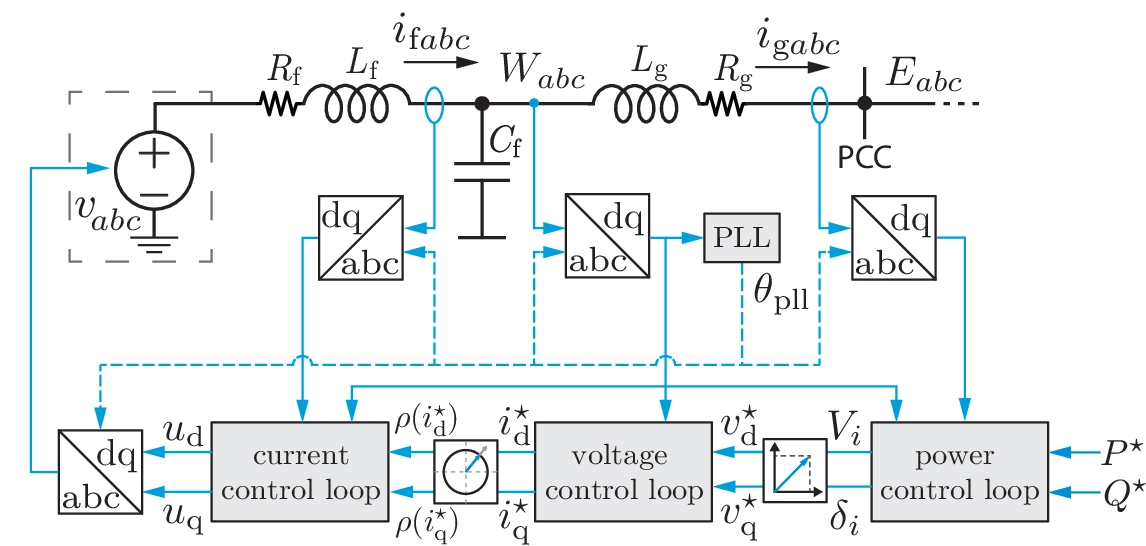

In [ ]:
# Create an empty dictionary to store the states and dynamics as they are defined
state_dynamics = {}
algebraic_expressions = {}

n_states = 12 # number of states
n_inputs = 2  # number of inputs
n_outputs = 2  # number of outputs

from sympy.physics.mechanics import init_vprinting
init_vprinting()

def display_alg_eq(lhs_exprs, rhs_exprs, eval=False, alist=True):
  if alist:
    return Eq(Matrix([[lhs] for lhs in lhs_exprs]), Matrix([[rhs] for rhs in rhs_exprs]), evaluate=eval)
  else:
    return Eq(lhs_exprs, rhs_exprs)
def display_diff_eq(states, dynamics, eval=False):
  return Eq(diff(Matrix([[state] for state in states])), Matrix([[dyn] for dyn in dynamics]), evaluate=eval)
def display_aligned_eqs(lhs, rhs):
  # Create the equation
  equation = Eq(lhs, rhs)
  # Convert the equation to LaTeX format
  latex_equation = latex(equation)
  # Display the LaTeX-formatted equation using Math
  return Math(r'\begin{align*}' + latex_equation + r'\end{align*}')

In [ ]:
""" DQ reference frame power equations """
vd, vq, id, iq = dynamicsymbols("v_\mathrm{d}, v_\mathrm{q}, i_\mathrm{d}, i_\mathrm{q}")
p, q = dynamicsymbols("P, Q")
P = 3/2 * (vd * id + vq * iq)
Q = 3/2 * (vq * id - vd * iq)
display_alg_eq([p, q], [P, Q])

⎡P⎤   ⎡1.5⋅i_\mathrm{d}⋅v_\mathrm{d} + 1.5⋅i_\mathrm{q}⋅v_\mathrm{q}⎤
⎢ ⎥ = ⎢                                                             ⎥
⎣Q⎦   ⎣1.5⋅i_\mathrm{d}⋅v_\mathrm{q} - 1.5⋅i_\mathrm{q}⋅v_\mathrm{d}⎦

In [ ]:
""" LCL filter """
# States
i_i_d, i_i_q = dynamicsymbols("I_{i\mathrm{d}}, I_{i\mathrm{q}}")  # inverter-side inductor currents
w_d, w_q = dynamicsymbols("W_{\mathrm{d}}, W_{\mathrm{q}}")  # capacitor voltages
i_g_d, i_g_q = dynamicsymbols("I_{g\mathrm{d}}, I_{g\mathrm{q}}")  # grid-side inductor currents

# Variables
v_i_d, v_i_q = var("V_{i\mathrm{d}}, V_{i\mathrm{q}}")  # inverter output voltage in the dq-reference frame wrt the reference angle theta_ref
e_D, e_Q = var("e_\mathrm{D}, e_\mathrm{Q}")  # grid voltages in the grid reference frame
e, omega_e = var("E, omega_e")  # grid voltage magnitude and angular frequency
v_nom, omega_nom = var("V_\mathrm{nom}, \omega_\mathrm{nom}")
r_i, l_i = var("R_i, L_i")  # inverter-side inductor resistance and inductance
r_c, c = var("R_c, C")  # capacitor resistance and capacitance
r_g, l_g = var("R_g, L_g")  # grid-side inductor resistance and inductance

omega_ref = var("\omega_\mathrm{ref}")  # angular frequency of the reference angle, theta_ref
grid_ref_delta  = var("\delta_g")  # angular difference between the grid voltage angle and the reference angle

# Collect direct-quadrature components into vectors
v_i_dq = Matrix([[v_i_d], [v_i_q]])
i_i_dq = Matrix([i_i_d, i_i_q])
w_dq = Matrix([[w_d], [w_q]])
i_g_dq = Matrix([i_g_d, i_g_q])
e_DQ = Matrix([[e_D], [e_Q]]).subs({e_D: sqrt(2)*e, e_Q: 0})  # Stiff-grid

# Algebraic equations
Rmat = lambda delta: Matrix([[cos(delta), sin(delta)], [-sin(delta), cos(delta)]]) # Counter-clockwise rotation matrix

E_dq = Rmat(grid_ref_delta) @ e_DQ  # convert grid voltage to reference theta_ref
E_q = E_dq[1]
E_d = E_dq[0]

# RL Branch dynamics
r, l = var("R, L")
i_d, i_q = dynamicsymbols("I_{\mathrm{d}}, I_{\mathrm{q}}")
i_dq = Matrix([[i_d], [i_q]])
v1_d, v1_q = dynamicsymbols("V_{1\mathrm{d}}, V_{1\mathrm{q}}")
v2_d, v2_q = dynamicsymbols("V_{2\mathrm{d}}, V_{2\mathrm{q}}")
v1_dq, v2_dq = Matrix([[v1_d], [v1_q]]), Matrix([[v2_d], [v2_q]])
A = Matrix([[-r / l, omega_ref], [-omega_ref, -r / l]])
I_dq_dot = A * i_dq + (v1_dq - v2_dq) / l
I_d_dot = I_dq_dot[0]
I_q_dot = I_dq_dot[1]

### LCL Filter Differential equations ###

# inverter-side inductor dynamics
L_i_subs = {i_d: i_i_d, i_q: i_i_q, r: r_i, l: l_i,
            v1_d: v_i_d, v1_q: v_i_q, v2_d: w_d, v2_q: w_q}
I_i_dot = I_dq_dot.subs(L_i_subs)
I_i_d_dot = I_i_dot[0]
I_i_q_dot = I_i_dot[1]

# grid-side inductor dynamics
L_g_subs = {i_d: i_g_d, i_q: i_g_q, r: r_g, l: l_g,
            v1_d: w_d, v1_q: w_q, v2_d: E_d, v2_q: E_q}
I_g_dot = I_dq_dot.subs(L_g_subs)
I_g_d_dot = I_g_dot[0]
I_g_q_dot = I_g_dot[1]

# capacitor dynamics
A_w = Matrix([[0, omega_ref], [-omega_ref, 0]])
W_dot = A_w * w_dq + (1 / c) * (i_i_dq - i_g_dq)
W_d_dot = W_dot[0]
W_q_dot = W_dot[1]

### Collect and display the dynamics ###
LCL_Filter_states = [*i_i_dq, *w_dq, *i_g_dq]
LCL_Filter_dynamics = [*I_i_dot, *W_dot, *I_g_dot]
state_dynamics.update(zip(LCL_Filter_states, LCL_Filter_dynamics))
display_diff_eq(LCL_Filter_states, LCL_Filter_dynamics)

                    ⎡                                        Rᵢ⋅I_{i\mathrm{d}
                    ⎢  \omega_\mathrm{ref}⋅I_{i\mathrm{q}} - ─────────────────
                    ⎢                                                Lᵢ       
                    ⎢                                                         
                    ⎢                                         Rᵢ⋅I_{i\mathrm{q
                    ⎢  -\omega_\mathrm{ref}⋅I_{i\mathrm{d}} - ────────────────
⎡I_{i\maṫhrm{d}}⎤   ⎢                                                 Lᵢ     
⎢               ⎥   ⎢                                                         
⎢I_{i\maṫhrm{q}}⎥   ⎢                                                 -I_{g\m
⎢               ⎥   ⎢            \omega_\mathrm{ref}⋅W_{\mathrm{q}} + ────────
⎢W_{\matḣrm{d}} ⎥   ⎢                                                        
⎢               ⎥ = ⎢                                                         
⎢W_{\matḣrm{q}} ⎥   ⎢                              

In [ ]:
""" Phase-lock Loop (PLL) """

# PLL states
pi_pll = dynamicsymbols(r"\Pi_\mathrm{pll}")  # PLL integral state
theta_pll = dynamicsymbols("theta_\mathrm{pll}")  # PLL angle
delta_pll = dynamicsymbols("\delta_\mathrm{pll}")  # PLL angle difference from grid voltage

# PLL parameters
omega_c = var("omega_c")  # cut-off frequency
k_p_pll, k_i_pll = var("k_{p_{pll}}, k_{i_{pll}}")  # PI control gains

### PLL Differential equations ###

Pi_pll_dot = w_q  # PLL at LCL capacitor / Point of common coupling
Theta_pll_dot = k_p_pll * Pi_pll_dot + k_i_pll * pi_pll + omega_e

Omega_pll = Theta_pll_dot
Delta_pll_dot = Omega_pll - omega_e

### Collect and display the dynamics ###
PLL_states = [pi_pll, delta_pll]
PLL_dynamics = [Pi_pll_dot, Delta_pll_dot]
state_dynamics.update(zip(PLL_states, PLL_dynamics))

display_diff_eq(PLL_states, PLL_dynamics)

⎡ \Pi_\matḣrm{pll}  ⎤   ⎡                     W_{\mathrm{q}}                 
⎢                   ⎥ = ⎢                                                     
⎣\delta_\mȧthrm{pll}⎦   ⎣k_{i_{pll}}⋅\Pi_\mathrm{pll} + k_{p_{pll}}⋅W_{\mathr

     ⎤
    ⎥
m{q}}⎦

In [ ]:
""" Power Controller """

# control inputs
u = Matrix(dynamicsymbols(','.join(['u_%s' % (i+1) for i in range(n_inputs)])))
v_i = dynamicsymbols("V_i")  # inverter voltage magnitude
p_ref, q_ref = symbols("P^*, Q^*")
theta_i, delta_i, omega_i = dynamicsymbols("\theta_i, \delta_i, \omega_i")  # inverter voltage angle and angular frequency
inv_ref_delta = delta_i  # angular difference between the inverter voltage angle and the reference angle

v_delta = Matrix([[v_i], [delta_i]])

# parameters
k = MatrixSymbol('K', n_inputs, n_outputs)

# linear feedback controller
y = Matrix(dynamicsymbols(','.join(['y_%s' % (i+1) for i in range(n_outputs)])))
f_u_K = k @ y
V_Delta_ref = k @ Matrix([[p - p_ref], [q - q_ref]])

V_i_dq_ref = Rmat(-inv_ref_delta) @ Matrix([[sqrt(2)*v_i], [0]])  # Clockwise rotation since V_i is not reference
V_i_d_ref = V_i_dq_ref[0]
V_i_q_ref = V_i_dq_ref[1]

algebraic_expressions.update(zip(v_delta, V_Delta_ref))

### Display the power controller expression ###
display_alg_eq(v_delta, V_Delta_ref, alist=False)

⎡  Vᵢ   ⎤     ⎡-P__* + P⎤
⎢       ⎥ = K⋅⎢         ⎥
⎣\deltaᵢ⎦     ⎣-Q__* + Q⎦

In [ ]:
""" Power expressions """
P_capacitor_grid = P.subs([(vd, w_d), (vq, w_q), (id, i_g_d), (iq, i_g_q)])
Q_capacitor_grid = Q.subs([(vd, w_d), (vq, w_q), (id, i_g_d), (iq, i_g_q)])

P_inv_grid = P.subs([(vd, sqrt(2)*v_i), (vq, 0.0), (id, i_g_d), (iq, i_g_q)])
Q_inv_grid = Q.subs([(vd, sqrt(2)*v_i), (vq, 0.0), (id, i_g_d), (iq, i_g_q)])

algebraic_expressions.update(zip([p, q], [P_capacitor_grid, Q_capacitor_grid]))
display_alg_eq([p, q], [P_capacitor_grid, Q_capacitor_grid])

⎡P⎤   ⎡1.5⋅I_{g\mathrm{d}}⋅W_{\mathrm{d}} + 1.5⋅I_{g\mathrm{q}}⋅W_{\mathrm{q}}
⎢ ⎥ = ⎢                                                                       
⎣Q⎦   ⎣1.5⋅I_{g\mathrm{d}}⋅W_{\mathrm{q}} - 1.5⋅I_{g\mathrm{q}}⋅W_{\mathrm{d}}

⎤
⎥
⎦

In [ ]:
""" Voltage Controller """
# states
phi_d, phi_q = dynamicsymbols("\Phi_\mathrm{d}, \Phi_\mathrm{q}")

# variables and parameters
rho = Function("rho")
I_max = var("I_\mathrm{max}")
i_d_ref, i_q_ref = var("I_\mathrm{d}^*, I_\mathrm{q}^*")
k_pv, k_iv, k_b = var("k_{pv}, k_{iv}, k_b")

# differential equations
Phi_d_dot = V_i_d_ref - w_d
Phi_q_dot = V_i_q_ref - w_q

# algebraic equations
I_d_ref = i_g_d + k_pv * Phi_d_dot + k_iv * phi_d - omega_nom * c * w_q
I_q_ref = i_g_q + k_pv * Phi_q_dot + k_iv * phi_q + omega_nom * c * w_d

### Collect and display the dynamics ###
Voltage_ctrl_states = [phi_d, phi_q]
Voltage_ctrl_dynamics = [Phi_d_dot, Phi_q_dot]
Voltage_ctrl_alg_lhs = [i_d_ref, i_q_ref]
Voltage_ctrl_alg_rhs = [I_d_ref, I_q_ref]

state_dynamics.update(zip(Voltage_ctrl_states, Voltage_ctrl_dynamics))
algebraic_expressions.update(zip(Voltage_ctrl_alg_lhs, Voltage_ctrl_alg_rhs))

display_diff_eq(Voltage_ctrl_states, Voltage_ctrl_dynamics), display_alg_eq(Voltage_ctrl_alg_lhs, Voltage_ctrl_alg_rhs)

⎛⎡\Phi_\mȧthrm{d}⎤   ⎡√2⋅Vᵢ⋅cos(\deltaᵢ) - W_{\mathrm{d}}⎤  ⎡I_\mathrm{d}__*⎤
⎜⎢               ⎥ = ⎢                                   ⎥, ⎢               ⎥ 
⎝⎣\Phi_\mȧthrm{q}⎦   ⎣√2⋅Vᵢ⋅sin(\deltaᵢ) - W_{\mathrm{q}}⎦  ⎣I_\mathrm{q}__*⎦

   ⎡-C⋅\omega_\mathrm{nom}⋅W_{\mathrm{q}} + k_{iv}⋅\Phi_\mathrm{d} + k_{pv}⋅(√
= ⎢                                                                           
   ⎣C⋅\omega_\mathrm{nom}⋅W_{\mathrm{d}} + k_{iv}⋅\Phi_\mathrm{q} + k_{pv}⋅(√2

2⋅Vᵢ⋅cos(\deltaᵢ) - W_{\mathrm{d}}) + I_{g\mathrm{d}}⎤⎞
                                                    ⎥⎟
⋅Vᵢ⋅sin(\deltaᵢ) - W_{\mathrm{q}}) + I_{g\mathrm{q}} ⎦⎠

In [ ]:
""" Current Controller """
# states
gamma_d, gamma_q = dynamicsymbols("\Gamma_\mathrm{d}, \Gamma_\mathrm{q}")

# variables and parameters
k_pi, k_ii = var("k_{pi}, k_{ii}")

# differential equations
Gamma_d_dot = i_d_ref - i_i_d
Gamma_q_dot = i_q_ref - i_i_q

# algebraic equations
V_i_d = (w_d + k_pi * Gamma_d_dot + k_ii * gamma_d - omega_nom * l_i * i_i_q)
V_i_q = (w_q + k_pi * Gamma_q_dot + k_ii * gamma_q + omega_nom * l_i * i_i_d)
V_i_dq = Matrix([[V_i_d], [V_i_q]])

### Collect and display the dynamics ###
Current_ctrl_states = [gamma_d, gamma_q]
Current_ctrl_dynamics = [Gamma_d_dot, Gamma_q_dot]
Current_ctrl_alg_lhs = [*v_i_dq]
Current_ctrl_alg_rhs = [*V_i_dq]

state_dynamics.update(zip(Current_ctrl_states, Current_ctrl_dynamics))
algebraic_expressions.update(zip(Current_ctrl_alg_lhs, [expr.subs(algebraic_expressions) for expr in Current_ctrl_alg_rhs]))  # Substitute in past algebraic expressions to avoid interdependence

display_diff_eq(Current_ctrl_states, Current_ctrl_dynamics), display_alg_eq(Current_ctrl_alg_lhs, Current_ctrl_alg_rhs)

⎛⎡\Gamma_\ṁathrm{d}⎤   ⎡I_\mathrm{d}__* - I_{i\mathrm{d}}⎤  ⎡V_{i\mathrm{d}}⎤
⎜⎢                 ⎥ = ⎢                                 ⎥, ⎢               ⎥ 
⎝⎣\Gamma_\ṁathrm{q}⎦   ⎣I_\mathrm{q}__* - I_{i\mathrm{q}}⎦  ⎣V_{i\mathrm{q}}⎦

   ⎡-Lᵢ⋅\omega_\mathrm{nom}⋅I_{i\mathrm{q}} + k_{ii}⋅\Gamma_\mathrm{d} + k_{pi
= ⎢                                                                           
   ⎣Lᵢ⋅\omega_\mathrm{nom}⋅I_{i\mathrm{d}} + k_{ii}⋅\Gamma_\mathrm{q} + k_{pi}

}⋅(I_\mathrm{d}__* - I_{i\mathrm{d}}) + W_{\mathrm{d}}⎤⎞
                                                     ⎥⎟
⋅(I_\mathrm{q}__* - I_{i\mathrm{q}}) + W_{\mathrm{q}} ⎦⎠

## Collect into a state-space system


In [ ]:
""" Collect states """
# x = Matrix([[v_i], [delta], [p_filt], [phi_d], [phi_q], [gamma_d], [gamma_q], [i_i_d], [i_i_q], [w_d], [w_q], [i_g_d], [i_g_q]])

x = Matrix([[delta_pll], [pi_pll], [phi_d], [phi_q], [gamma_d], [gamma_q], [i_i_d], [i_i_q], [w_d], [w_q], [i_g_d], [i_g_q]])
print("n_states", n_states, n_states == x.shape[0])
Eq(Symbol('x'), x, evaluate=False)

n_states 12 True


    ⎡\delta_\mathrm{pll}⎤
    ⎢                   ⎥
    ⎢ \Pi_\mathrm{pll}  ⎥
    ⎢                   ⎥
    ⎢  \Phi_\mathrm{d}  ⎥
    ⎢                   ⎥
    ⎢  \Phi_\mathrm{q}  ⎥
    ⎢                   ⎥
    ⎢ \Gamma_\mathrm{d} ⎥
    ⎢                   ⎥
    ⎢ \Gamma_\mathrm{q} ⎥
x = ⎢                   ⎥
    ⎢  I_{i\mathrm{d}}  ⎥
    ⎢                   ⎥
    ⎢  I_{i\mathrm{q}}  ⎥
    ⎢                   ⎥
    ⎢  W_{\mathrm{d}}   ⎥
    ⎢                   ⎥
    ⎢  W_{\mathrm{q}}   ⎥
    ⎢                   ⎥
    ⎢  I_{g\mathrm{d}}  ⎥
    ⎢                   ⎥
    ⎣  I_{g\mathrm{q}}  ⎦

In [ ]:
""" Collect dynamics """
ref_frame_subs = [(grid_ref_delta, delta_pll), (inv_ref_delta, delta_i),  # PLL reference frame
                  (omega_ref, Omega_pll),  # Inverter angular frequency expression
                  ]

x_dot_diff_eqs = Matrix([[state_dynamics[state]] for state in x])

display_diff_eq(x, x_dot_diff_eqs)

                        ⎡                   k_{i_{pll}}⋅\Pi_\mathrm{pll} + k_{
                        ⎢                                                     
                        ⎢                                         W_{\mathrm{q
                        ⎢                                                     
                        ⎢                              √2⋅Vᵢ⋅cos(\deltaᵢ) - W_
                        ⎢                                                     
⎡\delta_\mȧthrm{pll}⎤   ⎢                              √2⋅Vᵢ⋅sin(\deltaᵢ) - W
⎢                   ⎥   ⎢                                                     
⎢ \Pi_\matḣrm{pll}  ⎥   ⎢                               I_\mathrm{d}__* - I_{
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{d}  ⎥   ⎢                               I_\mathrm{q}__* - I_{
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{q}  ⎥   ⎢                          

In [ ]:
# Seperate out algebraic expressions into lists for display
key_value_pairs = list(algebraic_expressions.items())
x_dot_alg_eqs_LHS = [pair[0] for pair in key_value_pairs]
x_dot_alg_eqs_RHS = [pair[1] for pair in key_value_pairs]
display_alg_eq(x_dot_alg_eqs_LHS, x_dot_alg_eqs_RHS)

⎡       P       ⎤   ⎡                                                         
⎢               ⎥   ⎢                                                         
⎢       Q       ⎥   ⎢                                                         
⎢               ⎥   ⎢                                                         
⎢I_\mathrm{d}__*⎥   ⎢                                                        -
⎢               ⎥ = ⎢                                                         
⎢I_\mathrm{q}__*⎥   ⎢                                                         
⎢               ⎥   ⎢                                                         
⎢V_{i\mathrm{d}}⎥   ⎢-Lᵢ⋅\omega_\mathrm{nom}⋅I_{i\mathrm{q}} + k_{ii}⋅\Gamma_\
⎢               ⎥   ⎢                                                         
⎣V_{i\mathrm{q}}⎦   ⎣ Lᵢ⋅\omega_\mathrm{nom}⋅I_{i\mathrm{d}} + k_{ii}⋅\Gamma_\

                           1.5⋅I_{g\mathrm{d}}⋅W_{\mathrm{d}} + 1.5⋅I_{g\mathr
                                                   

In [ ]:
# Display full dynamics with algebraic expressions substituted in
x_dot = Matrix([[state_dynamics[state]] for state in x]).subs(algebraic_expressions).subs(ref_frame_subs)
display_diff_eq(x, x_dot)

                        ⎡                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
⎡\delta_\mȧthrm{pll}⎤   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢ \Pi_\matḣrm{pll}  ⎥   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{d}  ⎥   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{q}  ⎥   ⎢                          

In [ ]:
x_fullorder = Matrix(x)
x_dot_fullorder = Matrix(x_dot)  # Save nonlinear system model for comparison later on, from here on out linearized model will be used

### Current limiting

The magnitude of the current at the inverter terminals must be limited to the value that the switches of the inverter are rated to carry. Current limiting is practically achieved with this system by saturating the current reference, $I_\mathrm{dq}^*$, from the voltage control loop before it is passed to the current controller. The magnitude of the current reference is saturated to the maximum allowable value as
$$
\mathrm{sat}(I_\mathrm{dq}^*) =
\begin{cases}
I_\mathrm{dq}^* & \mathrm{if} & \|I_\mathrm{dq}^*\| \leq I_\mathrm{max}\\
\frac{I_\mathrm{max}}{\|I_\mathrm{dq}^*\|} I_\mathrm{dq}^* & \mathrm{if} & \|I_\mathrm{dq}^*\| > I_\mathrm{max} \\
\end{cases},
$$
which can also be expressed as
$$
\mathrm{sat}(I_\mathrm{dq}^*) = \frac{I_\mathrm{max}}{\mathrm{max}(\|I_\mathrm{dq}^*\|, I_\mathrm{max})} \cdot I_\mathrm{dq}^*
$$

In [ ]:
# Display dynamics with current saturation
rho = sym.Function('\mathrm{sat}')
display_diff_eq(x, x_dot.subs(I_d_ref.subs(ref_frame_subs), rho(i_d_ref)).subs(I_q_ref.subs(ref_frame_subs), rho(i_q_ref)))

                        ⎡                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
⎡\delta_\mȧthrm{pll}⎤   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢ \Pi_\matḣrm{pll}  ⎥   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{d}  ⎥   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{q}  ⎥   ⎢                          

## Apply simplifying assumptions

To reduce the system order and simplify analysis we ignore the dynamics of the capacitor and treat the LCL filter simply as an RL line. We also make small-angle difference assumptions, a linearizing assumption on the power calculations, and the assumption that the PLL tracks quickly enough to ignore its dynamics.

With our assumption that we can ignore the capacitor dynamics, the inner voltage and current control loops are also ignored. In order to still consider the magnitude saturation on the current reference that occurs between the voltage and current control loops, we instead treat this as a limit applied directly to the inductor current state in the simplified system.

In [ ]:
# Assumptions made to get a linear system
ref_frame_subs = {grid_ref_delta: delta_i, # Assume PLL and inverter output angle align
                  inv_ref_delta: 0}

power_v_assum = {w_d: sqrt(2)*v_nom, w_q: 0}
assumption_subs = [(P_capacitor_grid, P_capacitor_grid.subs(power_v_assum)), # Power measurement expressions w/ linear assumption (delta << makes W_d ~ V_nom, W_q ~ 0)
                   (Q_capacitor_grid, Q_capacitor_grid.subs(power_v_assum)),
                   (sin(delta_i), delta_i), (cos(delta_i), 1), # Small-angle difference assumption
                   (omega_ref, omega_nom), (omega_e, omega_nom), # Assume constant inverter angular frequency for LCL filter dynamics
                  ]  # Linearizing assumptions
algebraic_subs = [(omega_ref, Omega_pll),  # Inverter angular frequency expression
                  ]

In [ ]:
# Define the reduced-order system
x_reduced = Matrix([[i_d], [i_q]])  # Note that we ignore all states except for the inductor currents.
u_vars = Matrix([[v_i], [delta_i]])  # The voltage magnitude and angle are taken to be inputs

simplified_RL_subs = {v1_d: V_i_d_ref, v1_q: V_i_q_ref, v2_d: E_d, v2_q: E_q}
x_dot_reduced_inv = Matrix([[I_d_dot], [I_q_dot]]).subs(simplified_RL_subs).subs(ref_frame_subs).subs(algebraic_subs)
x_dot_affine_inv =  Matrix([[I_d_dot], [I_q_dot]]).subs(simplified_RL_subs).subs(ref_frame_subs).subs(assumption_subs)

x_dot_reduced, x_dot_affine = x_dot_reduced_inv, x_dot_affine_inv

display_diff_eq(x_reduced, x_dot_affine)

                   ⎡                                     R⋅I_{\mathrm{d}}   -√
                   ⎢\omega_\mathrm{nom}⋅I_{\mathrm{q}} - ──────────────── + ──
⎡I_{\matḣrm{d}}⎤   ⎢                                            L            
⎢              ⎥ = ⎢                                                          
⎣I_{\matḣrm{q}}⎦   ⎢√2⋅E⋅\deltaᵢ                                        R⋅I_{
                   ⎢──────────── - \omega_\mathrm{nom}⋅I_{\mathrm{d}} - ──────
                   ⎣     L                                                    

2⋅E + √2⋅Vᵢ⎤
───────────⎥
     L      ⎥
           ⎥
\mathrm{q}} ⎥
────────── ⎥
 L         ⎦

### Simplified system

In [ ]:
A = x_dot_affine.jacobian(x_reduced)
B = x_dot_affine.jacobian(u_vars)

system_equations = latex(diff(x_reduced))+'='+latex(A)+latex(x_reduced)+'+'+latex(B)+latex(u_vars)
Math(system_equations)

<IPython.core.display.Math object>

This represent the inverter system in the form
$$
\dot{x} = A x + B u.
$$
where

In [ ]:
x = Matrix(x_reduced)
u = Matrix(u_vars)
n = len(x)
m = len(u)

A_sym, B_sym = symbols('A, B')
x_sym, u_sym = symbols('x, u')
Eq(A_sym, A, evaluate=False), Eq(B_sym, B, evaluate=False), Eq(x_sym, x, evaluate=False), Eq(u_sym, u, evaluate=False)

⎛    ⎡        -R                               ⎤      ⎡√2      ⎤              
⎜    ⎢        ───           \omega_\mathrm{nom}⎥      ⎢──   0  ⎥              
⎜    ⎢         L                               ⎥      ⎢L       ⎥      ⎡I_{\mat
⎜A = ⎢                                         ⎥, B = ⎢        ⎥, x = ⎢       
⎜    ⎢                              -R         ⎥      ⎢    √2⋅E⎥      ⎣I_{\mat
⎜    ⎢-\omega_\mathrm{nom}          ───        ⎥      ⎢0   ────⎥              
⎝    ⎣                               L         ⎦      ⎣     L  ⎦              

                       ⎞
                       ⎟
hrm{d}}⎤      ⎡  Vᵢ   ⎤⎟
       ⎥, u = ⎢       ⎥⎟
hrm{q}}⎦      ⎣\deltaᵢ⎦⎟
                       ⎟
                       ⎠

In [ ]:
# define x_dot here from the linear system
x_dot = A @ x + B @ u

Eq(diff(x), x_dot)

                   ⎡                                        R⋅I_{\mathrm{d}}  
                   ⎢   \omega_\mathrm{nom}⋅I_{\mathrm{q}} - ──────────────── +
⎡I_{\matḣrm{d}}⎤   ⎢                                               L         
⎢              ⎥ = ⎢                                                          
⎣I_{\matḣrm{q}}⎦   ⎢√2⋅E⋅\deltaᵢ                                        R⋅I_{
                   ⎢──────────── - \omega_\mathrm{nom}⋅I_{\mathrm{d}} - ──────
                   ⎣     L                                                    

 √2⋅Vᵢ    ⎤
 ─────    ⎥
    L      ⎥
          ⎥
\mathrm{q}}⎥
──────────⎥
 L        ⎦

### Discretization & Current limiting

Now to include the current limits and formulate an optimal control problem, we discretize the system as follows.

In [ ]:
# Discretization parameters
delta_t = 1e-4
dt, Delta, k, t = symbols('{\Delta}t, \Delta, k, t')

In [ ]:
# Discretize the system using forward euler discretization
A_ = eye(n) + A * dt
B_ = B * dt

A_, B_

⎛⎡           R⋅{\Delta}t                                       ⎤  ⎡√2⋅{\Delta}
⎜⎢       1 - ───────────          \omega_\mathrm{nom}⋅{\Delta}t⎥  ⎢───────────
⎜⎢                L                                            ⎥  ⎢     L     
⎜⎢                                                             ⎥, ⎢           
⎜⎢                                           R⋅{\Delta}t       ⎥  ⎢           
⎜⎢-\omega_\mathrm{nom}⋅{\Delta}t         1 - ───────────       ⎥  ⎢     0     
⎝⎣                                                L            ⎦  ⎣           

t                ⎤⎞
─        0       ⎥⎟
                 ⎥⎟
                 ⎥⎟
   √2⋅E⋅{\Delta}t⎥⎟
   ──────────────⎥⎟
         L       ⎦⎠

In [ ]:
# Discretized differential equation

x_t_plus = A_ @ x_reduced + B_ @ u_vars

# Print differential equations
discrete_system_equations = latex((x_reduced).subs(t, t+dt))+'='+latex(A_)+latex(x_reduced.subs(t, t))+'+'+latex(B_)+latex(u_vars.subs(t, t))
Math(discrete_system_equations)

<IPython.core.display.Math object>

We now have the system in the form
$$
x_{t+1} = \bar{A} x_{t} + \bar{B} u_{t},
$$
where

In [ ]:
A_bar_sym, B_bar_sym = symbols('Abar, Bbar')
Eq(A_bar_sym, A_, evaluate=False), Eq(B_bar_sym, B_, evaluate=False), Eq(x_sym, x, evaluate=False), Eq(u_sym, u, evaluate=False)

⎛    ⎡           R⋅{\Delta}t                                       ⎤      ⎡√2⋅
⎜    ⎢       1 - ───────────          \omega_\mathrm{nom}⋅{\Delta}t⎥      ⎢───
⎜    ⎢                L                                            ⎥      ⎢   
⎜A̅ = ⎢                                                             ⎥, B̅ = ⎢ 
⎜    ⎢                                           R⋅{\Delta}t       ⎥      ⎢   
⎜    ⎢-\omega_\mathrm{nom}⋅{\Delta}t         1 - ───────────       ⎥      ⎢   
⎝    ⎣                                                L            ⎦      ⎣   

{\Delta}t                ⎤                                     ⎞
─────────        0       ⎥                                     ⎟
  L                      ⎥      ⎡I_{\mathrm{d}}⎤      ⎡  Vᵢ   ⎤⎟
                           ⎥, x = ⎢              ⎥, u = ⎢       ⎥⎟
           √2⋅E⋅{\Delta}t⎥      ⎣I_{\mathrm{q}}⎦      ⎣\deltaᵢ⎦⎟
  0        ──────────────⎥                                     ⎟
                 L       ⎦                            

To reintroduce the current magnitude limits we apply the saturation function directly to the states of the simplified system as

$$
x_{t+1} = \bar{A} \; \mathrm{sat}(x_{t}) + \bar{B} u_{t}.
$$

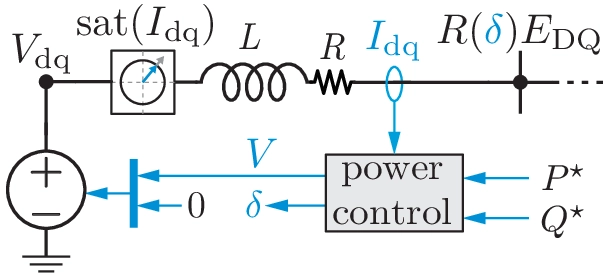

## Numerical Parameters

In this section we define the numerical parameters used in simulations.

In [ ]:
# Numeric parameters for the inverter system
s_rated = 1500.  # W
f_nom = 60.  # Hz
v_nom_val = 120.  # Vrms LN
i_max = s_rated / (3 * v_nom_val)  # A

e_val = v_nom_val
omega_e_val = f_nom * 2*np.pi

# LCL filter parameters
r_i_val, r_g_val = 0.4, 0.9  # NOTE: grid-side includes line resistance
l_i_val, l_g_val = 1.5e-3, 2e-3  # NOTE: grid-side includes line inductance
r_c_val, c_val, = 0.05, 10e-7  # NOTE: r_c_val currently unused

r_val = r_i_val + r_g_val
l_val = l_i_val + l_g_val

# Control parameters
pref0 = 0.5 * s_rated
qref0 = 0.5 * s_rated

# Voltage & current control loops
"""
NOTE: The results in the paper use these faster frequencies,
however for a practical system the lower values commented out
below are more reasonable. Either option work well within this
notebook.
"""
freq_cur = 10000 #3000
freq_vol = 2000 #800

omega_cur = 2*pi * freq_cur
omega_vol = 2*pi * freq_vol

kpv = 2*omega_vol*c
kiv = 2*kpv * omega_vol**2 / omega_cur

kpi = l_i * omega_cur
kii = r_i * omega_cur

# PLL parameters
pll_nf = 40
pll_dr = 1.0
kipll = pll_nf**2 / (np.sqrt(2)*v_nom_val)
kppll = 2 * pll_dr * pll_nf*2*np.pi / (np.sqrt(2)*v_nom_val)

dt_val = delta_t  # assigned at the start of the discretize section

In [ ]:
# Dictionaries of numerical parameters
inner_loop_sym_subs = {k_pv: kpv, k_iv: kiv, k_pi: kpi, k_ii: kii}

symbolic_subs = {omega_e: omega_e, I_max: i_max}

current_loop_subs = {k_pi: kpi, k_ii: kii}
voltage_loop_subs = {k_pv: kpv, k_iv: kiv}
pll_subs = {k_i_pll: kipll, k_p_pll: kppll}
control_subs = {**current_loop_subs, **voltage_loop_subs, **pll_subs}

lcl_param_subs = {r: r_val, l: l_val, r_i: r_i_val, l_i: l_i_val, r_c: r_c_val, c: c_val, r_g: r_g_val, l_g: l_g_val}
nominal_subs = {v_nom: v_nom_val, e: e_val, e_Q: 0, omega_e: omega_e_val, omega_nom: 2*pi.evalf()*f_nom}
numeric_subs = {**lcl_param_subs, **nominal_subs}  # Combine numerical substitutions into one dictionary

# pack all subs into one
sim_subs = {**symbolic_subs, **numeric_subs, **nominal_subs, dt: dt_val}

## Formulate the control problem

We have the system
$$
x_{t+1} = \bar{A} \; \mathrm{sat}(x_{t}) + \bar{B} u_{t},
$$
where
$\bar{A} = \left[\begin{matrix}1 - \frac{R {\Delta}t}{L} & \omega_\mathrm{nom} {\Delta}t\\- \omega_\mathrm{nom} {\Delta}t & 1 - \frac{R {\Delta}t}{L}\end{matrix}\right]$,
$\bar{B} = \left[\begin{matrix}\frac{\sqrt{2} {\Delta}t}{L} & 0\\0 & \frac{\sqrt{2} E {\Delta}t}{L}\end{matrix}\right]$,
$x_t = \begin{bmatrix}I_{d}{\left(t \right)}\\I_{q}{\left(t \right)}\end{bmatrix}$,
$u_t = \begin{bmatrix}V(t)\\ \delta(t) \end{bmatrix}$.

where $R = R_i + R_g$, and $L = L_i + L_g$.

We want to develop a controller to determine the inputs $u$ to achieve the desired trajectory response.

We will try a linear feedback controller where
$$
u_t = \begin{bmatrix}V(t)\\ \delta(t) \end{bmatrix} = -K \cdot \mathrm{sat}(x_t)
$$

We formulate the problem of solving for the optimal inputs to the discrete time system as the nonconvex constrained optimization problem
$$
\begin{array}{rl}
\displaystyle
\min_{u_1, \dots, u_T} \sum_{i = 1}^{T} \quad & (x_i - x^*)^\top Q (x_i - x^*) + u_{i}^\top R u_{i}  \\
\textrm{s.t.} \quad &
x_{t+1} = \bar{A} \; \mathrm{sat}(x_{t}) + \bar{B} u_{t} \\
\quad &
x_{0} = x_\mathrm{init} \\
\end{array}
$$

# Preliminary simulations & Data generation

## Define simulation functions

In [ ]:
# Simulates a discrete linear system with state and input saturation
def simulate_saturated_discrete_linear_system(A, B, u_func, cost_fn, x0, x_ref,
                                              end_sim_funcs, sat_x, sat_u, b=0,
                                              args=None, end_sim_args=None,
                                              sat_u_args=None, sat_x_args=None,
                                              verbose=False,
                                              ):
  """
  end_sim_funcs:  A list of function to determine when to stop the simulation.
                  Each function must take arguments (t, xs, us, x_ref, *end_sim_args[i]),
                  where end_sim_args is a list constaining tuples are arguments to pass
                  to each function. If any function returns True, the simulation ends.
  """
  end_sim_args = [() for f in end_sim_funcs] if end_sim_args is None else end_sim_args

  x = np.array(x0)
  u = np.zeros(x.shape)

  xs = [x0]
  us = []
  t = 0
  while not np.any([func(t, xs, us, x_ref, *fargs) for func, fargs in zip(end_sim_funcs, end_sim_args)]):
    if verbose and t % verbose == 0:
      print("simulation t=%s" % (t))
    u = u_func(A, B, cost_fn, x, x_ref) if args is None else u_func(A, B, cost_fn, x, x_ref, *args)
    u = sat_u(u) if sat_u_args is None else sat_u(u, *sat_u_args)

    x = A @ x + B @ u + b
    x = sat_x(x) if sat_x_args is None else sat_x(x, *sat_x_args)

    xs.append(x)
    us.append(u)
    t += 1
  if verbose:
    print("simulation complete")

  return xs, us

def time_limit_reached(t, xs, us, x_ref, T):
  return t > T

def states_converged(t, xs, us, x_ref, tol, lookback=5, min_T=0):
  xs_lookback = xs[-lookback:]
  xt_converged = [((x - x_ref).T @ (x - x_ref)) < tol for x in xs_lookback]
  return np.all(xt_converged) and (t > min_T)

def saturate_2norm(x, x_lim, x_delta=0):
  # Circular saturation of the vector x + x_delta to the magnitude x_lim
  x_shift = x + x_delta
  x_norm = np.linalg.norm(x_shift, ord=2)
  if x_norm > x_lim:
    x_shift_sat = x_shift * x_lim / x_norm
    return x_shift_sat - x_delta
  return x

def saturate(xs, x_mins, x_maxs, x_delta=0):
  # Element-wise saturation of the xs + x_delta vector values between x_mins and x_maxs
  return np.clip(xs, x_mins, x_maxs)

def x_err_2_norm(x, u, x_ref):
  # Alternate cost function for MPC simulations
  return cp.norm2(x - x_ref)

def check_x0_2norm(x0, limit=1.0):
  # Check that the 2norm of a vector is less than or equal to the given limit
  norms = np.linalg.norm(x0, axis=0, ord=2)  # Check that the reference does not exceed the state limits
  return not(np.any(norms >= limit)), np.max(norms)

## Initialize simulation parameters

In [ ]:
# Simulation parameters
x_norm_max = i_max  # set the magnitude limit to the nominal current

x_point = np.array([1, 1])
x0 = x_norm_max*0.99 * x_point / np.linalg.norm(x_point) # initial state value

T_base = int(0.02 / dt_val) # simulation length (steps)
N = 5 # optimization horizon for MPC (steps)
print("T:",T_base,"N:",N)

x_refs = -x0[:, None] * np.ones((n, T_base+N))   # set desired state values at each time index

print("||x|| max:", x_norm_max)
print("Valid x0:", check_x0_2norm(x0, x_norm_max))
print("Valid xref:", check_x0_2norm(x_refs, x_norm_max))

x0_sim = x0 - x_refs[:, 0]
x_ref_sim = np.zeros((1, T_base + N + 1))  # Give x_ref to be 0 since we center the equilibrium around the reference above for sims

T: 200 N: 5
||x|| max: 4.166666666666667
Valid x0: (True, 4.125)
Valid xref: (True, 4.125)


In [ ]:
# Substitute in numerical values for system parameters
A_num = np.array(A_.subs(sim_subs).evalf()).astype(np.float64)
B_num = np.array(B_.subs(sim_subs).evalf()).astype(np.float64)

Eq(A_bar_sym, Matrix(A_num), evaluate=False), Eq(B_bar_sym, Matrix(B_num), evaluate=False)

⎛    ⎡ 0.962857142857143   0.0376991118430775⎤      ⎡0.0404061017820884       
⎜A̅ = ⎢                                       ⎥, B̅ = ⎢                       
⎝    ⎣-0.0376991118430775  0.962857142857143 ⎦      ⎣        0           4.848

  0        ⎤⎞
             ⎥⎟
73221385061⎦⎠

In [ ]:
# Define a baseline controller and verify that it stabalizes the system
K_base = np.array([[0.5, 0.0],
                  [0.0, 0.01]
                  ])

print(np.linalg.eigvals(A_num - B_num @ K_base))

[0.92851196+0.034946j 0.92851196-0.034946j]


In [ ]:
# Define cost functions
def cost(xs, us, x_refs, args):
  if len(x_refs.shape) < 2:
    x_refs = [x_refs for i in range(len(xs))]
  return np.sum([LQR_cost(x, u, x_ref, **args) for x, u, x_ref in zip(xs, us, x_refs)])

def LQR_cost(x, u, x_ref, Q=None, R=None):
  Q = np.eye(xs.shape[0]) if Q is None else Q
  R = np.eye(us.shape[0]) if R is None else R
  delta_xT = x.T - x_ref.T  # Order of operations required for gurobipy
  delta_x = x - x_ref
  return delta_xT @ Q @ delta_x + u.T @ R @ u

Q = np.array([[1, 0],
              [0, 1]])  # State costs
R = B_num*5  # Arbitrarily chosen input costs
cost_args = {'Q': Q, 'R': R}

In [ ]:
# Specify constraint values
"""
For the paper the input constraints are set to be large enough that they are
not reached by the optimal MPC control.
We only include the constraints as they speed up the NMPC problem significantly.
Note that the values below are not typical limit values for practical
grid applications.
"""

V_delta_max = 0.2 * v_nom_val
v_min, v_max = - V_delta_max , V_delta_max
delta_min, delta_max = -np.pi / 2, np.pi / 2

# Input constraints
u_max = [v_max, delta_max]
u_min = [v_min, delta_min]

print("Maximum input values:", u_max, "\nMinimum input values", u_min)

Maximum input values: [24.0, 1.5707963267948966] 
Minimum input values [-24.0, -1.5707963267948966]


## Linear Feedback

### Stability analysis

In [ ]:
# Finds the eigenvalues and their magnitudes for a linear discrete-time system
#           x_{t+1} = A x_t - B K x_t
def check_disc_eigvals(A, B, K, verbose=True):
  eig_vals = np.linalg.eigvals(A + B @ -K)
  print("Eigenvalues:", eig_vals)
  eig_val_mags = np.array([np.abs(eig) for eig in eig_vals])
  print("Magnitudes:", eig_val_mags)
  stable = np.all(eig_val_mags < 1)
  print("Stable:",stable)
  return eig_vals, eig_val_mags, stable

In [ ]:
# Note that we selected the base linear feedback controller
display(Matrix(K_base))  # print feedback with variables

# and it is small-signal stable
print('\nK_base')
check_disc_eigvals(A_num, B_num, K_base);

⎡0.5   0  ⎤
⎢         ⎥
⎣ 0   0.01⎦


K_base
Eigenvalues: [0.92851196+0.034946j 0.92851196-0.034946j]
Magnitudes: [0.92916935 0.92916935]
Stable: True


### Simulate with linear feedback $K_\mathrm{base}$

In [ ]:
# Define the static linear feedback controller for simulations
def linear_feedback_control(A, B, cost_fn, x, x_ref, K=K_base):
  return -K @ x

In [ ]:
# Simulate the system with the static linear feedback controller

args = [K_base]
sat_u_args = [u_min, u_max]
sat_x_args = [x_norm_max, x_refs[:, 0]]

end_sim_funcs = [time_limit_reached]
xs, us = simulate_saturated_discrete_linear_system(A_num, B_num, linear_feedback_control, x_err_2_norm, x0_sim, x_refs,
                                                   end_sim_funcs, saturate_2norm, saturate, verbose=T_base//10,
                                                   args=args, end_sim_args=[(T_base-1,)],
                                                   sat_x_args=sat_x_args, sat_u_args=sat_u_args)

xs += x_refs.T[:T_base+1, :]
xs_Kbase = np.array(xs)  # Save a copy for later use
us_Kbase = np.array(us)

simulation t=0
simulation t=20
simulation t=40
simulation t=60
simulation t=80
simulation t=100
simulation t=120
simulation t=140
simulation t=160
simulation t=180
simulation complete


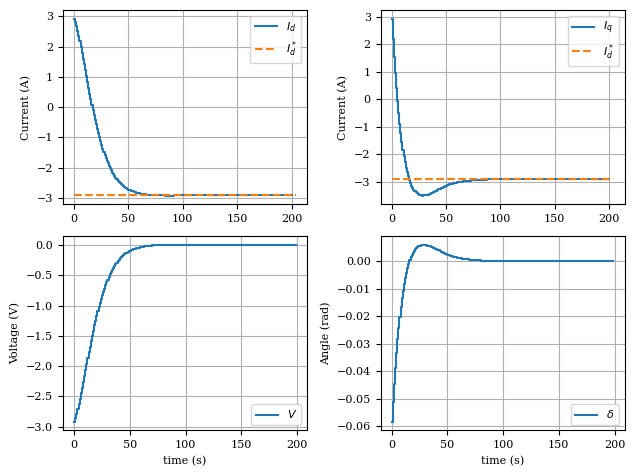

In [ ]:
# Plot states and inputs
plt.subplot(2, 2, 1)
plt.plot(np.array(xs)[:, 0], label='$I_d$', drawstyle='steps-post')
plt.plot(x_refs[0, :], label='$I_d^*$', linestyle='--', drawstyle='steps-post')
plt.legend(), plt.grid(), plt.ylabel('Current (A)')
plt.subplot(2, 2, 2)
plt.plot(np.array(xs)[:, 1], label='$I_q$', drawstyle='steps-post')
plt.plot(x_refs[1, :], label='$I_d^*$', linestyle='--', drawstyle='steps-post')
plt.legend(), plt.grid(), plt.ylabel('Current (A)')

plt.subplot(2, 2, 3)
plt.plot(np.array(us)[:, 0], label='$V$', drawstyle='steps-post')
plt.axhline(u_max[0], linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(np.array(us)[:, 0]) >= u_max[0] else None
plt.axhline(u_min[0], linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(np.array(us)[:, 0]) <= u_min[0] else None
plt.legend(), plt.grid(), plt.xlabel('time (s)'), plt.ylabel('Voltage (V)')
plt.subplot(2, 2, 4)
plt.plot(np.array(us)[:, 1], label='$\delta$', drawstyle='steps-post')
plt.axhline(u_max[1], linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(np.array(us)[:, 1]) >= u_max[1] else None  # Only plot limits if the input hits or exceeds them
plt.axhline(u_min[1], linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(np.array(us)[:, 1]) <= u_min[1] else None
plt.legend(), plt.grid(), plt.xlabel('time (s)'), plt.ylabel('Angle (rad)')
plt.tight_layout()

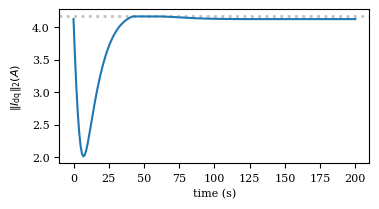

In [ ]:
# Plot the 2-norm magnitude of the states
fig = plt.figure(figsize=(4, 2))
x_magnitude = np.linalg.norm(xs, axis=1)
plt.axhline(x_norm_max, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.plot(x_magnitude), plt.xlabel('time (s)'), plt.ylabel("$\| I_\mathrm{dq} \|_2 (A)$");

## Model Predictive Control (MPC)

### NMPC optimization problem formulation

In [ ]:
# Implementation of NMPC with saturation using Gurobi

# Define the mpc controller
def mpc_control(A, B, cost_fn, x0, x_ref, N=10, x_delta=0, u_max=None, u_min=None, x_norm_max=None, cost_args={}, return_all=False):
    """
    Calculate the input to a linear discrete-time system using MPC control.

    Parameters:
    - A: State matrix of the linear system.
    - B: Input matrix of the linear system.
    - cost_fn: Custom cost function that takes x, u, and x_ref as inputs and returns a scalar cost.
    - N: Prediction horizon.
    - x0: Initial state of the system.
    - x_ref: Reference state trajectory.

    Returns:
    - u_opt: Optimal input trajectory.
      """
    n_states = A.shape[0]  # Number of states
    n_inputs = B.shape[1]  # Number of inputs
    sat_lim = x_norm_max

    try:
        ### Create a new model ###
        m = gp.Model("nmpc")
        m.params.OutputFlag = 0  # Set to not be verbose
        m.params.NonConvex = 2  # Set to be nonconvex

        ### Define optimization variables ###

        # Create state variable matrix using NumPy
        x = m.addMVar((n_states, N + 1), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="x")  # State trajectory
        x_norm = m.addMVar(N + 1, vtype=GRB.CONTINUOUS, ub=GRB.INFINITY, name="x_norm")
        norm_max = m.addMVar(N + 1, vtype=GRB.CONTINUOUS, ub=GRB.INFINITY, name="norm_max")
        norm_div = m.addMVar(N + 1, vtype=GRB.CONTINUOUS, ub=GRB.INFINITY, name="norm_div")
        x_sat = m.addMVar((n_states, N + 1), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="x_sat")
        u = m.addMVar((n_inputs, N), vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="u")  # Input trajectory

        ### Define constraints ###

        # Define constraints and objective function
        m.addConstr(x[:, 0] == x0)
        cost_terms = []
        for k in range(N):
          x_ref_k = x_ref[:, k] if len(x_ref.shape) > 1 else x_ref
          cost_terms.append(cost_fn(x[:, k], u[:, k], x_ref_k, **cost_args))

          # Dynamics constraint
          """
          Want to add constraint, but need to use aux vars
          x[:, k + 1] == A @ (x[:, k] / max(||x[:, k]||, 1)) + B @ u[:, k]
          """
          m.addConstr(x_norm[k] == gp.norm(x[:, k], 2))  # Get the 2-norm of x[k]
          m.addConstr(norm_max[k] == gp.max_(x_norm[k], sat_lim))  # Find the maximum of the limit and the norm
          m.addConstr(norm_div[k] * norm_max[k] == sat_lim)  # Constraint such that we can divide by norm_max
          m.addConstr(x_sat[:, k] == x[:, k] * norm_div[k], name="sat_x")  # Apply saturation function
          m.addConstr(x[:, k + 1] == A @ x_sat[:, k] + B @ u[:, k], name="dyn step %s" % k)  # Dynamics step  constraint

          # Unsaturated
          #m.addConstr(x[:, k + 1] == A @ x[:, k] + B @ u[:, k], name="dyn step %s" % k)

          # Input saturation constraints
          m.addConstr(u[0, k] <= u_max[0])
          m.addConstr(u[0, k] >= u_min[0])
          m.addConstr(u[1, k] <= u_max[1])
          m.addConstr(u[1, k] >= u_min[1])


        ### Define the objective ###

        # Set objective
        cost = gp.quicksum(cost_terms)
        m.setObjective(cost, GRB.MINIMIZE)

        ### Solve the problem ###

        # Optimize model
        m.optimize()

        if m.status != GRB.OPTIMAL:
          raise Exception("Optimization problem did not converge! %s" % m.status)

        # Print the value of all optimization variables for debugging
        # for v in m.getVars():
        #     print('%s %g' % (v.VarName, v.X))
        #print('Obj: %g' % m.ObjVal)

        # Extract the optimal input trajectory
        u_opt = u.X[:, 0]

        if return_all:
          return (u.X, x.X)
        return u_opt

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    return None

### Simulate with MPC

In [ ]:
# Simulate the system with the mpc controller

# Run the simulation
#       N: optimization horizon, x_delta: state ref offset, u_max: input max, u_min: input min, x_norm_max: state max norm
mpc_args = [N, x_refs[:, 0], u_max, u_min, x_norm_max, cost_args]

sat_u_args = [u_min, u_max]
sat_x_args = [x_norm_max, x_refs[:, 0]]

print("MPC %s period simulation with %s period optimization horizons:" % (T_base, N))
end_sim_funcs = [time_limit_reached]
t0 = time.time()
xs, us = simulate_saturated_discrete_linear_system(A_num, B_num, mpc_control, LQR_cost, x0_sim, x_ref_sim,
                                                   end_sim_funcs, saturate_2norm, saturate, verbose=T_base//10,
                                                   args=mpc_args, end_sim_args=[(T_base-1,)],
                                                   sat_x_args=sat_x_args, sat_u_args=sat_u_args)
t1 = time.time()
runtime_total = t1-t0
print("runtime:", runtime_total, 's')

xs_zero = np.array(xs)
xs += x_refs.T[:T_base+1, :]
xs_mpc = np.array(xs)
us_mpc = np.array(us)

MPC 200 period simulation with 5 period optimization horizons:
simulation t=0
simulation t=20
simulation t=40
simulation t=60
simulation t=80
simulation t=100
simulation t=120
simulation t=140
simulation t=160
simulation t=180
simulation complete
runtime: 52.769434690475464 s


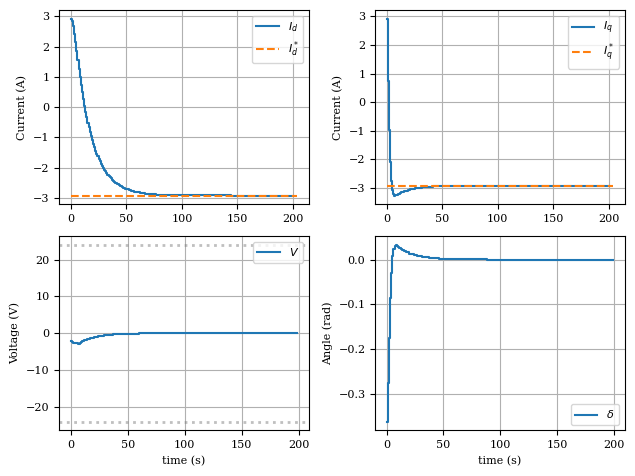

In [ ]:
# Plot state and input trajectories for the MPC controlled system
plt.subplot(2, 2, 1)
plt.plot(xs_mpc[:, 0], label='$I_d$', drawstyle='steps-post')
plt.plot(x_refs[0, :], label='$I_d^*$', linestyle='--', drawstyle='steps-post')
plt.legend(), plt.grid(), plt.ylabel('Current (A)')
plt.subplot(2, 2, 2)
plt.plot(xs_mpc[:, 1], label='$I_q$', drawstyle='steps-post')
plt.plot(x_refs[1, :], label='$I_q^*$', linestyle='--', drawstyle='steps-post')
plt.legend(), plt.grid(), plt.ylabel('Current (A)')

plt.subplot(2, 2, 3)
plt.plot(us_mpc[:, 0], label='$V$', drawstyle='steps-post')
plt.axhline(v_max, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.axhline(v_min, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.legend(), plt.grid(), plt.xlabel('time (s)'), plt.ylabel('Voltage (V)')
plt.subplot(2, 2, 4)
plt.plot(us_mpc[:, 1], label='$\delta$', drawstyle='steps-post')
plt.axhline(delta_max, linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(us_mpc[:, 1]) >= delta_max else None  # Only plot limits if the input hits or exceeds them
plt.axhline(delta_min, linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.min(us_mpc[:, 1]) <= delta_min else None
plt.legend(), plt.grid(), plt.xlabel('time (s)'), plt.ylabel('Angle (rad)')
plt.tight_layout()

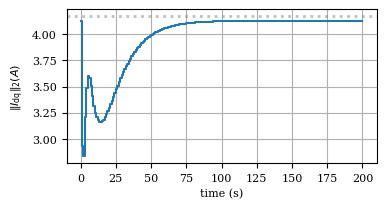

In [ ]:
# Plot the 2-norm magnitude of the states
fig = plt.figure(figsize=(4, 2))
x_magnitude = np.linalg.norm(xs_mpc, axis=1)
plt.axhline(x_norm_max, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.plot(x_magnitude, drawstyle='steps-post'), plt.xlabel('time (s)'), plt.ylabel("$\| I_\mathrm{dq} \|_2 (A)$");
plt.grid();

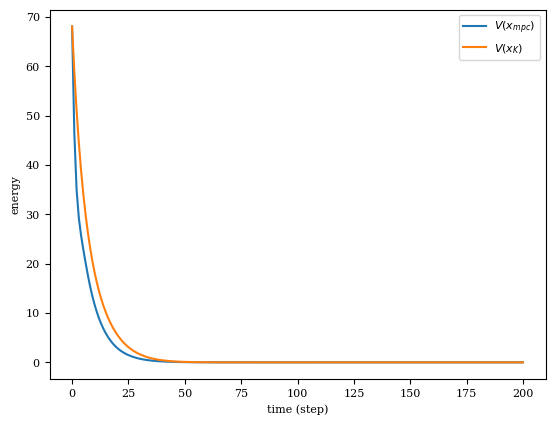

In [ ]:
# Plot lyapunov energy function vs time for the MPC and Base controllers
plt.plot([x.T @ np.eye(n) @ x for x in (xs_mpc - x_refs.T[:T_base+1, :])], label='$V(x_{mpc})$')
plt.plot([x.T @ np.eye(n) @ x for x in (xs_Kbase  - x_refs.T[:T_base+1, :])], label='$V(x_{K})$')
plt.xlabel("time (step)")
plt.ylabel("energy")
plt.legend()

In [ ]:
# Evaluate and compare costs of Kbase and MPC controllers
cost_mpc = cost(xs_mpc, us_mpc, x_refs.T, cost_args)
cost_K = cost(xs_Kbase, us_Kbase, x_refs.T, cost_args)
print("MPC cost: %s, Linear K cost: %s" % (cost_mpc, cost_K))

MPC cost: 411.54405714637255, Linear K cost: 577.2712809147132


### Data generation

Now we generate data with the MPC controller for a range of steps in the inputs. This data will later be used to fit a static linear feedback matrix.

In [ ]:
# Simulate with MPC control for a range of steps in id_ref, iq_ref
"""
NOTE: This cell takes a while to run as it is running (mag_sweep_steps^2 x rad_sweep_steps^2)
      rolling horizon NMPC simulations. This further emphasizes the need to perform this offline
      and the importance of imitating this NMPC controller rather than implementing it.
"""
T_data_max = int(0.05 / dt_val) # simulation length (steps)
converge_tol = 1e-4
converge_steps = 10

# NOTE: Similar performance can be found with less simulation data / fewer samples here
#######################
mag_sweep_steps = 3
rad_sweep_steps = 4
rad_sweep_start = np.pi / 4

x0_mag_sweep_bounds = [0.0, i_max-1e-6]  # Bounds on the magnitudes for x0, xref
xref_mag_sweep_bounds = [0.0, i_max-1e-6]  # Bounds on the magnitudes for x0, xref
rad_sweep_bounds = [0, 2*np.pi - 2*np.pi / rad_sweep_steps]  # Bounds on the angles for x0, xref
# Drop the 2*pi value to avoid repeated tests (cos(2*pi) = cos(0) = 1)
#######################

# Polar coordinates sweep over magnitude limiter
x0_mag_sweep = np.linspace(x0_mag_sweep_bounds[0], x0_mag_sweep_bounds[1], mag_sweep_steps)
xref_mag_sweep = np.linspace(xref_mag_sweep_bounds[0], xref_mag_sweep_bounds[1], mag_sweep_steps)
rad_sweep = np.linspace(rad_sweep_bounds[0], rad_sweep_bounds[1], rad_sweep_steps) + rad_sweep_start

# Create a mesh grid of the sweep values
x0_mag, x0_rad, xref_mag, xref_rad = np.meshgrid(x0_mag_sweep, rad_sweep, xref_mag_sweep, rad_sweep)

# Convert polar to cartesian coordinates
id_ref_values = xref_mag * np.cos(xref_rad)
iq_ref_values = xref_mag * np.sin(xref_rad)

x0_rad_offset = 0 # np.pi / rad_sweep_steps  # Offset x0 and xref when using fewer samples
x0_id_values = x0_mag * np.cos(x0_rad + x0_rad_offset)
x0_iq_values = x0_mag * np.sin(x0_rad + x0_rad_offset)

n_cases = len(id_ref_values.flatten())

test_x0s = np.vstack([x0_id_values.ravel(), x0_iq_values.ravel()])
test_xrefs = np.vstack([id_ref_values.ravel(), iq_ref_values.ravel()])

# Simulate and collect data for the MPC response
print("Running MPC %s period maximum test simulations with %s period optimization horizons:" % (T_data_max, N))

xs_mpc_data = []
us_mpc_data = []
xrefs_mpc_data = []
x0s_mpc_data = []
for i, (x0_, x_ref_) in enumerate(zip(test_x0s.T, test_xrefs.T)):
  print("\nCase", i+1,'/',n_cases, "\nid(0):", x0_[0], "iq(0):", x0_[1], "id*:", x_ref_[0], "iq*:", x_ref_[1])

  valid_xref = check_x0_2norm(x_ref_, x_norm_max)
  valid_x0 = check_x0_2norm(x0_, x_norm_max)
  print("x_ref is valid?:", valid_xref, x_ref_)
  print("x0 is valid?:", valid_x0, x0_)
  if not(valid_xref[0] and valid_x0[0]):
    print("NOT RUNNING SIMULATION: Invalid x0 or xref (%s, %s)" % (x0_, x_ref_))
  elif np.all(x_ref_ == x0_):
    print("NOT RUNNING SIMULATION: x0 and xref are equal (%s, %s)" % (x0_, x_ref_))
  else:
    x0_sim_ = x0_ - x_ref_
    x_ref_sim_ = np.zeros(n) # Give x_ref to be 0 since we center the equilibrium around the reference above

    # Run simulation
    #       N: optimization horizon, x_delta: state ref offset, u_max: input max, u_min: input min, x_norm_max: state max norm
    mpc_args = [N, x_ref_, u_max, u_min, x_norm_max, cost_args]

    # Simulate with saturation in dynamics
    sat_u_args = [u_min, u_max]
    sat_x_args = [x_norm_max, x_ref_]

    end_sim_funcs = [time_limit_reached, states_converged]
    xs, us = simulate_saturated_discrete_linear_system(A_num, B_num, mpc_control, LQR_cost,
                                                       x0_sim_, x_ref_sim_, end_sim_funcs,
                                                       saturate_2norm, saturate, verbose=10,
                                                       args=mpc_args, end_sim_args=[(T_data_max,), (converge_tol, converge_steps)],
                                                       sat_x_args=sat_x_args, sat_u_args=sat_u_args)

    xs_zero = np.array(xs)[:-converge_steps, :]  # Trim converged step data
    us_np = np.array(us)[:-converge_steps, :]

    x0s_mpc_data.append(x0_)
    xrefs_mpc_data.append(x_ref_)

    xs_mpc_data.append(xs_zero)
    us_mpc_data.append(us_np)

n_data_sims = len(xrefs_mpc_data)
print("Ran %s / %s tests" % (n_data_sims, n_cases))

Running MPC 500 period maximum test simulations with 5 period optimization horizons:

Case 1 / 144 
id(0): 0.0 iq(0): 0.0 id*: 0.0 iq*: 0.0
x_ref is valid?: (True, 0.0) [0. 0.]
x0 is valid?: (True, 0.0) [0. 0.]
NOT RUNNING SIMULATION: x0 and xref are equal ([0. 0.], [0. 0.])

Case 2 / 144 
id(0): 0.0 iq(0): 0.0 id*: -0.0 iq*: 0.0
x_ref is valid?: (True, 0.0) [-0.  0.]
x0 is valid?: (True, 0.0) [0. 0.]
NOT RUNNING SIMULATION: x0 and xref are equal ([0. 0.], [-0.  0.])

Case 3 / 144 
id(0): 0.0 iq(0): 0.0 id*: -0.0 iq*: -0.0
x_ref is valid?: (True, 0.0) [-0. -0.]
x0 is valid?: (True, 0.0) [0. 0.]
NOT RUNNING SIMULATION: x0 and xref are equal ([0. 0.], [-0. -0.])

Case 4 / 144 
id(0): 0.0 iq(0): 0.0 id*: 0.0 iq*: -0.0
x_ref is valid?: (True, 0.0) [ 0. -0.]
x0 is valid?: (True, 0.0) [0. 0.]
NOT RUNNING SIMULATION: x0 and xref are equal ([0. 0.], [ 0. -0.])

Case 5 / 144 
id(0): 0.0 iq(0): 0.0 id*: 1.4731387739185835 iq*: 1.4731387739185833
x_ref is valid?: (True, 2.0833328333333334) [1.473

In [ ]:
# Check that the smallest and largest input values are not reaching the input constraint bounds
vmin_v, vmax_v = np.min([np.min(us[:, 0]) for us in us_mpc_data]), np.max([np.max(us[:, 0]) for us in us_mpc_data])
vmin_d, vmax_d = np.min([np.min(us[:, 1]) for us in us_mpc_data]), np.max([np.max(us[:, 1]) for us in us_mpc_data])

print("V is bound to (%s, %s), delta is bound to (%s, %s)" % (u_min[0], u_max[0], u_min[1], u_max[1]))
print("V data is in  (%s, %s), delta data is in  (%s, %s)" % (vmin_v, vmax_v, vmin_d, vmax_d))

V is bound to (-24.0, 24.0), delta is bound to (-1.5707963267948966, 1.5707963267948966)
V data is in  (-2.8217632241163297, 2.81846196030568), delta data is in  (-0.5019942873610393, 0.5019942873610393)


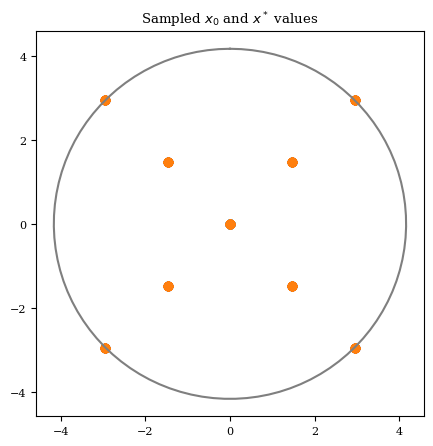

In [ ]:
# Plot all x_ref and x_0 points used during the tests to visualize the sampled grid
fig = plt.figure(figsize=(5,5))
plot_circle(x_norm_max, np.zeros(n), fig=fig, plt_args={'label': "$\|x\|_2=I_\mathrm{max}$", 'linestyle': '-', 'color': 'C7'});  # Circular limiter

plt.scatter(np.array(xrefs_mpc_data)[:, 0], np.array(xrefs_mpc_data)[:, 1])
plt.scatter(np.array(x0s_mpc_data)[:, 0], np.array(x0s_mpc_data)[:, 1])
plt.title("Sampled $x_0$ and $x^*$ values");

In [ ]:
# Create a gif of the 3D plot for visualization of the MPC control inputs

from matplotlib.animation import FuncAnimation
from matplotlib import colormaps as cmaps

# Create the 3D plot
fig = plt.figure(figsize=(15,6))

cm = cmaps.get_cmap('RdYlBu')

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
axs = [ax1, ax2]

scs = []
# Find the smallest and largest input values for setting the bounds of the color bar
vmin_v, vmax_v = np.min([np.min(us[:, 0]) for us in us_mpc_data]), np.max([np.max(us[:, 0]) for us in us_mpc_data])
vmin_d, vmax_d = np.min([np.min(us[:, 1]) for us in us_mpc_data]), np.max([np.max(us[:, 1]) for us in us_mpc_data])
for xs_, us_ in zip(xs_mpc_data, us_mpc_data):
  sc1 = ax1.scatter(xs_[:-1, 0], xs_[:-1, 1], us_[:, 0], c=us_[:, 0], cmap=cm, vmin=vmin_v, vmax=vmax_v)
  sc2 = ax2.scatter(xs_[:-1, 0], xs_[:-1, 1], us_[:, 1], c=us_[:, 1], cmap=cm, vmin=vmin_d, vmax=vmax_d)
  scs.append(sc1)
  scs.append(sc2)
for ax in axs:
  ax.set_xlabel('$I_d$')
  ax.set_ylabel('$I_q$')
for ax in axs:
  ylim = ax.get_ylim()
  xlim = ax.get_xlim()
  ax.set_ylim(xlim)

ax1.set_title(r"$\Delta V$")
ax2.set_title(r"$\delta$")

axs[0].view_init(elev=10., azim=0)
axs[1].view_init(elev=10., azim=0)

# Generate GIF Using Matplotlib
num_frames = 60 #360

def init_plot():
  axs[0].view_init(elev=10., azim=0)
  axs[1].view_init(elev=10., azim=0)
  return ()

# Animation function
def animate(frame_number):
    if frame_number % 10 == 0:
      print("Frame %s / %s" % (frame_number, num_frames))
    i = 360 * frame_number / num_frames
    axs[0].view_init(elev=20., azim=i)
    axs[1].view_init(elev=20., azim=i)
    return () # tuple(scs)

animation = FuncAnimation(fig, animate, frames=num_frames, init_func=init_plot,
                          interval=100, repeat_delay=1000, blit=True)
fname = 'mpc_response_animation.gif'
animation.save(fname, writer='pillow');  # Use 'pillow' writer for GIFs
plt.close()

Frame 0 / 60
Frame 10 / 60
Frame 20 / 60
Frame 30 / 60
Frame 40 / 60
Frame 50 / 60


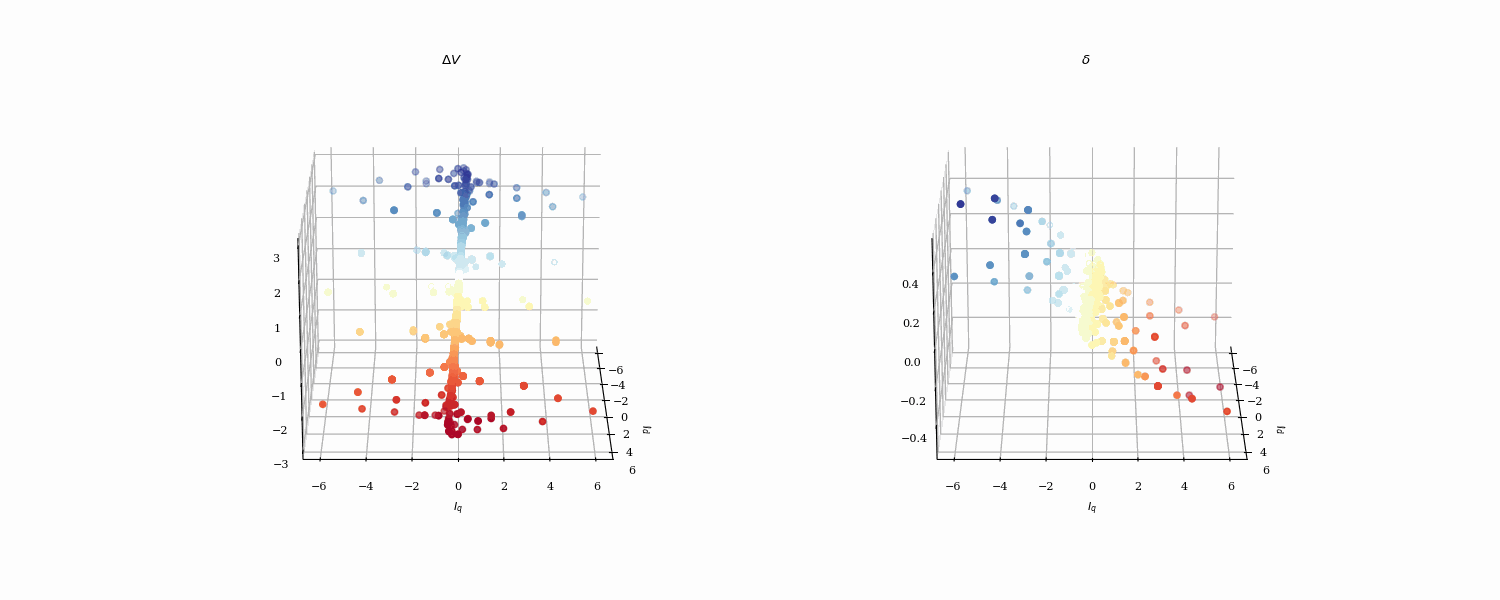

In [ ]:
# Display the GIF
from IPython.display import Image, display

fname = 'mpc_response_animation.gif'
Image(open(fname,'rb').read())

# Stability proof

We want to select a linear feedback controller that has similar performance to the MPC controller and guarentees stability of the system.

We start by noting the discrete-time Lyapunov equation. Given the system
$$
\Delta x_{t+1} = A (\Delta x_t) + B u(\Delta x_t), \quad u(\Delta x_t) = -K(\Delta x_t),
$$
if we select the Lyapunov energy function $V(z) = z^\top P z$ then the system is stable if $V(\Delta x_{t+1}) < V(\Delta x_t) \forall \Delta x_t \in \mathbb{R}^2$. From linear Lyapunov theory this is true if for any $Q \succ 0$ there exists a unique $P \succ 0$ such that
$$
(A - BK)^\top P (A - B K) - P + Q = 0.
$$

## Stability intuitions

Next we build some intuition into how including saturation on the states of this system can lead to issues with stability and how circular level sets help avoid these issues.

1. The states can get stuck against the saturation bound



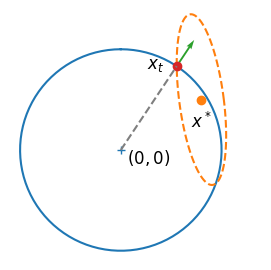

In [ ]:
# Create a figure showing the state stuck against the saturation bound
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[0]))

origin = (0, 0)
Rotation = np.array(Rmat(-np.pi / 24)).astype(np.float64())
P = Rotation @ np.array([[15, 0], [0, 1]]) @ Rotation.T

xs_circle1, fig = plot_circle(1, origin, fig=fig)

a = Symbol('a')
xs_point = np.array([1.0, 1.5])
xs_point /= np.linalg.norm(xs_point)
x_ref_point = np.array([0.8, 0.5])

ell_scale = 1 / ((xs_point - x_ref_point).T @ P @ (xs_point - x_ref_point))
xs_circle2, fig = plot_ellipse(ell_scale*P, x_ref_point, fig=fig, plt_args = {'linestyle': '--'})

annotation_args = {'fontsize': 12}
plot_point_with_annotation(xs_point, '$x_{t}$', offset=(-15, -2), plt_args={'marker': 'o', 'color':'C3'}, annotation_args=annotation_args)
plot_point_with_annotation(origin, '$(0, 0)$', offset=(20, -10), plt_args={'marker': '+', 'color':'C0'}, annotation_args=annotation_args)
plot_point_with_annotation(x_ref_point, '$x^*$', offset=(0, -20), plt_args={'marker': 'o', 'color':'C1'}, annotation_args=annotation_args)  #'marker':(5, 2), 'markersize':7,

sat_tan_normal = (xs_point) / 8  # Scaled to be within frame
args = {'scale': 1, 'color':'C2'}  # GREEN
plot_vector(xs_point, sat_tan_normal, args)

args = {'linestyle':'--', 'color':'C7'}  #BLUE
plot_line(origin, xs_point, args)

# Feasible dynamics vector
# args = {'scale': 1, 'color':'C1'}
# xs_step_point = np.array([1, 1]) / 7
# plot_vector(xs_point, xs_step_point, args)

axs = fig.get_axes()
plt.axis('equal')
# plt.ylim(0.5, 1.0)
# plt.xlim(0.5, 1.0)

# Remove the ticks or tick labels
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Set font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(30)

# Remove the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.legend()
# Zoom to desired view
plt.ylim(-1.1, 1.4)
plt.xlim(-1.1, 1.4);

fname="stuck_state_example.eps"
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

2. Circular saturation will always reduce the value of the energy function if we select $V(z) = z^\top P z, P = I$.

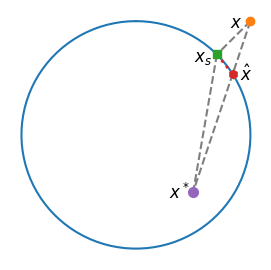

In [ ]:
# Create the figure showing that saturation reduces energy when P = I
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[0]))

def norm(z):
  return sqrt(z[0]**2 + z[1]**2)

x_point = np.array([1, 1])
xs_point = saturate_2norm(x_point, 1)

point_ref = np.array([0.5, -0.5])
z = Symbol('z')
x_hat_z = solve(norm(x_point + (x_point - point_ref) * z) - 1, z)
x_hat = x_point + (x_point - point_ref) * x_hat_z[1]

xs_circle, fig = plot_circle(1, (0, 0), fig=fig)

args = {'linestyle':'--', 'color':'C7'}
plot_line(x_point, xs_point, args)
plot_line(x_point, point_ref, args)
plot_line(xs_point, point_ref, args)
plot_line(xs_point, x_hat, {'linestyle':':', 'color':'C3', 'lw':2})

plot_point_with_annotation(x_point, '$x$', offset=(-10, -5), plt_args={'marker': 'o'}, annotation_args=annotation_args)
plot_point_with_annotation(xs_point, '$x_s$', offset=(-10, -5), plt_args={'marker': 's'}, annotation_args=annotation_args)
plot_point_with_annotation(x_hat, '$\hat{x}$', offset=(10, -5), plt_args={'marker': 'h'}, annotation_args=annotation_args)
plot_point_with_annotation(point_ref, '$x^*$', offset=(-10, -5), plt_args={'marker': 'o', 'markersize':7}, annotation_args=annotation_args)  # marker (5, 2)

# Remove the ticks or tick labels
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Set font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# Remove the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.legend()
# Zoom to desired view
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1);

fname="saturation_reduces_energy.eps"
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

3. If the system has circular Lyapunov level sets then the states can never get stuck.

[0.3   0.075]


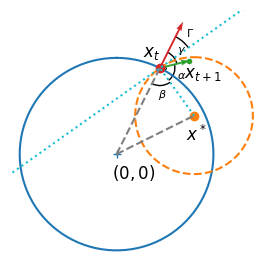

In [ ]:
# Create the figure showing the no stuck state proof when P = I
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[0]))

x_ref_point = (0.8, 0.4)
origin = (0, 0)

x_point = np.array([1, 2])
xs_point = saturate_2norm(x_point, 1)
xs_point_step = np.array([0.3, 0.075])
xs_point_stepped = xs_point + xs_point_step
print(xs_point_step)

xs_circle1, fig = plot_circle(1, origin, fig=fig)
level_set_radius = np.linalg.norm(xs_point - x_ref_point)
xs_circle2, fig = plot_circle(level_set_radius, x_ref_point, fig=fig, plt_args = {'linestyle': '--'})
axs = fig.get_axes()

w = x_ref_point - xs_point  # Normal
b = -w @ xs_point  # Offset
x_val1 = -1.5
x_val2 = 1.5

y_val1 = -(w[0]*x_val1 + b) / w[1]
y_val2 = -(w[0]*x_val2 + b) / w[1]

tangent_line_pnt1 = np.array([x_val1, y_val1])
tangent_line_pnt2 = np.array([x_val2, y_val2])

sat_tan_normal = (x_point - xs_point) / 6  # Scaled to be within frame

plot_point_with_annotation(xs_point_stepped, '$x_{t+1}$', offset=(10, -12), plt_args={'marker': '.'}, annotation_args=annotation_args)
plot_point_with_annotation(xs_point, '$x_{t}$', offset=(-6, 8), plt_args={'marker': 'o'}, annotation_args=annotation_args)
plot_point_with_annotation(origin, '$(0, 0)$', offset=(12, -18), plt_args={'marker': '+', 'color':'C0'}, annotation_args=annotation_args)
plot_point_with_annotation(x_ref_point, '$x^*$', offset=(2, -18), plt_args={'marker': 'o', 'color': 'C1'}, annotation_args=annotation_args)  #marker (5, 2)

args = {'linestyle':'--', 'color':'C7'}
plot_line(origin, x_ref_point, args)
plot_line(origin, xs_point, args)

args = {'linestyle':':', 'color':'C9'}
plot_line(tangent_line_pnt1, tangent_line_pnt2, args)  # Tangent Line
plot_line(x_ref_point, xs_point, args)  # Tangent Line

args = {'scale': 2.5, 'color':'C2'}
plot_vector(xs_point, xs_point_step, args)
args = {'scale': 1.0, 'color':'C3'}
plot_vector(xs_point, sat_tan_normal, args)

# Angle annotations
box_size = 0.05
right1 = mpl.patches.Rectangle(xs_point,box_size,box_size, fc=[0,0,0,0], ec="black", zorder=0, lw=.7,
                               rotation_point=tuple(xs_point), angle=-50)
axs[0].add_patch(right1)

#NOTE: Adding angle annotations make the saved figure blank
am1 = AngleAnnotation(xs_point, x_ref_point, xs_point_stepped, ax=axs[0],
                      size=30, text=r"$\alpha$",
                      textposition="outside", zorder=0)  # Proof step 1 angle
am2 = AngleAnnotation(xs_point, origin, x_ref_point, ax=axs[0],
                      size=35, text=r"$\beta$",
                      textposition="outside", zorder=0)  # Proof step 2 angle
am3 = AngleAnnotation(xs_point, xs_point_stepped, sat_tan_normal+xs_point, ax=axs[0],
                      size=35, text=r"$\gamma$",
                      textposition="outside", zorder=0)  # Non-zero angle
am4 = AngleAnnotation(xs_point, tangent_line_pnt2, sat_tan_normal+xs_point, ax=axs[0],
                      size=70, text=r"$\Gamma$",
                      textposition="outside", zorder=0)  # Non-zero angle


# Remove the ticks or tick labels
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Set font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

# Remove the axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.ylim(-1.1, 1.5)
plt.xlim(-1.1, 1.5);

fname="no_stuck_states.eps"
fig.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       );

## **Stability with State Saturation Proof**

**Proposition.**
Given the system
$$
x_t = x^* + \Delta x_t \\
\Delta x_{t+1} = A (\bar{x}_t - x^*) + B u (\bar{x} - x^*) \\
\bar{x}_t = \mathrm{sat}(\Delta x_t + x^*),
$$
where
$$
\mathrm{sat}(z) =
\begin{cases}
z, & \|z\|_2 \leq 1 \\
\frac{z}{\|z\|_2}, & \|z\|_2 > 1
\end{cases}, z \in \mathbb{R}^2
$$
and $x^* \in \{ x^* | \|x^* \|_2 < 1 \}$ and $x_0 \in \{ x_0 | \|x_0 \|_2 \leq 1 \}$ are given, the system is stable and has a unique equilibrium at $x^*$ if we select $u(x_t) = K x_t$ where $K$ satisfies the constraint
$$
(A - B K)^\top (A - B K) - I \prec 0.
$$

***Proof.***
We select the Lyapunov function $V(z) = z^\top P z$. If we can show that $V(\Delta x_{t+1}) < V(\Delta x_{t}) \forall x_t \in \mathbb{R}^2$, then we can conclude that the system is Lyapunov stable.

**Case 1.** If $\| \Delta x_{t} + x^* \|_2 \leq 1$, then $\Delta x_{t+1} = A(\Delta x_{t}) + B u (\Delta x_{t})$. Then the system is stable if for any $Q \succ 0$ there exists a unique $P \succ 0$ such that
$$
(A - BK)^\top P (A - B K) - P + Q = 0.
$$

**Case 2.** If $\| \Delta x_{t} + x^* \|_2 > 1$, then we have the step dynamics

$$
\Delta x_{t+1} = (A - B K) \left( \frac{\Delta x_t + x^*}{\| \Delta x_t + x^* \|_2} - x^* \right).
$$

Assuming we can select $K$ such that $(A - B K)^\top (A - B K) - I \prec 0$. then we can find the bound
$$
V(\Delta x_{t+1}) < \left\| \frac{\Delta x_t + x^*}{\| \Delta x_t + x^* \|_2} - x^* \right\|^2_2
$$

Further this selection of $K$, implies that $P = I, Q = I - (A - B K)^\top (A - B K)$ is a solution to the Lyapunov equation from **Case 1**.

We now want to show that
$$
V(\Delta x_{t+1}) < \left\| \frac{\Delta x_t + x^*}{\| \Delta x_t + x^* \|_2} - x^* \right\|^2_2
<
V(\Delta x_{t}) = \| \Delta x_{t} \|^2_2,
$$
which can be simplified using $x_t = \Delta x_t + x^*$ to get
$$
\left\| \frac{\Delta x_t + x^*}{\| \Delta x_t + x^* \|_2} - x^* \right\|^2_2
<
\| x_{t} - x^* \|^2_2.
$$


We now define an orthogonal bases $\{ x_t, v \}$ where $v \perp x_t$, and note that we can write $x^*$ in terms of this vector space basis as
$$
x^* = c_1 x_t + c_2 v,
$$
where $c_1 = \frac{\langle x_t, x^* \rangle}{\|x_t\|_2^2}$ and the term $c_1 x_t$ represent the projection of $x^*$ onto $x_t$.


Using this expression for $x^*$ and the triangle inequality, noting orthogonality, we find that
$$
\left\| x_{t} - x^* \|^2_2 =
x_t - \frac{\langle x_t, x^* \rangle}{\|x_t\|_2^2} x_t \right\|^2_2 + \| c_2 v \|_2^2
$$
and
$$
\left\| \frac{\Delta x_t + x^*}{\| \Delta x_t + x^* \|_2} - x^* \right\|^2_2
=
\left\| \frac{\Delta x_t + x^*}{\| \Delta x_t + x^* \|_2} - \frac{\langle x_t, x^* \rangle}{\|x_t\|_2^2} x_t \right\|^2_2 + \| c_2 v \|_2^2.
$$
Plugging this back into the inequality and using the absolute homogeneity propoerty of the norm to pull out scalar coefficients we have
$$
\left(1 - \frac{\langle x^*, x_t \rangle}{\| x_t \|_2^2} \right)^2 \| x_t \|_2^2
>
\left(\frac{1}{\| x_t \|_2} - \frac{\langle x^*, x_t \rangle}{\| x_t \|_2^2} \right)^2 \| x_t \|_2^2.
$$
This inequality holds true if
$$
\frac{\langle x^*, x_t \rangle}{\| x_t \|_2^2} < \frac{1}{\| x_t \|_2} < 1.
$$

First note that we start this case with $\| x_t \|_2^2 > 1$ which implies that $\frac{1}{\| x_t \|_2} \in (0, 1)$ and therefore $\frac{1}{\| x_t \|_2} < 1$.

Next, we manipulate the inequality $\frac{\langle x^*, x_t \rangle}{\| x_t \|_2^2}$ by squaring both sides and then applying the Cauchy-Schwarz inequlity ($| \langle x^*, x_t \rangle |_2^2 \leq \| x^* \|_2^2 \cdot \| x_t \|_2^2$) to get
$$
\frac{\langle x^*, x_t \rangle}{\| x_t \|_2^2}
\leq \frac{\| x^* \|_2^2 \cdot \| x_t \|_2^2}{\| x_t \|_2^4}
= \frac{\| x^* \|_2}{\| x_t \|_2}
< \frac{1}{\| x_t \|_2},
$$
which is true since we are given $\| x^* \|_2 < 1$. $\blacksquare$



---



## **Unknown Line Parameters Stability Proof**

**Proposition.** If the parameters of the grid-side line inductance and resistance are unknown, then it suffices to design the controller assuming the grid side resistance is $0$ and conclude stability. This leads to a suboptimal, but robust controller.

**Proof.** We have
$$
A =
I -
\Delta t \left[\begin{matrix} \frac{R}{L} & \omega_\mathrm{nom}\\- \omega_\mathrm{nom} & \frac{R}{L}\end{matrix}\right]
=
I -
\Delta t \hat{A}
$$

$$
B =
\Delta t \left[\begin{matrix}\frac{\sqrt{2}}{L} & 0\\0 & \frac{\sqrt{2} E}{L}\end{matrix}\right] = \Delta t \hat{B}
$$
where
$$
\hat{A} = \left[\begin{matrix} \frac{R}{L} & \omega_\mathrm{nom}\\- \omega_\mathrm{nom} & \frac{R}{L}\end{matrix}\right]
$$
$$
\hat{B} = \left[\begin{matrix}\frac{\sqrt{2}}{L} & 0\\0 & \frac{\sqrt{2} E}{L}\end{matrix}\right]
$$
and we want to show that the system is stable with $P = I$ and $u = -K x$. That is
$$
(A - BK) (A - BK)^\top - I \prec 0.
$$



For $\Delta t$ sufficiently small, that is a sufficiently fine discretization, we can assume terms containing $\Delta t^2$ are approximately zero.

Expanding and ignoring $\Delta t^2$ terms we get
$$
-\Delta t (\hat{A}^\top + K^\top \hat{B}^\top + \hat{A} + \hat{B} K) \prec 0,
$$
or
$$
\hat{A}^\top + K^\top \hat{B}^\top + \hat{A} + \hat{B} K \succ 0
$$
or
$$
\left[\begin{matrix} 2\frac{R}{L} & 0 \\ 0 & 2\frac{R}{L}\end{matrix}\right]^\top
+ K^\top \left[\begin{matrix}\frac{\sqrt{2}}{L} & 0\\0 & \frac{\sqrt{2} E}{L}\end{matrix}\right]^\top
+ \left[\begin{matrix}\frac{\sqrt{2}}{L} & 0\\0 & \frac{\sqrt{2} E}{L}\end{matrix}\right] K \succ 0
$$



Assuming $L > 0$ we have
$$
\left[\begin{matrix} 2 R & 0 \\ 0 & 2 R \end{matrix}\right]^\top
+ K^\top \left[\begin{matrix} \sqrt{2} & 0\\0 & \sqrt{2} E \end{matrix}\right]^\top
+ \left[\begin{matrix} \sqrt{2} & 0\\0 & \sqrt{2} E \end{matrix}\right] K \succ 0.
$$

Now we note that there is a monotonicity here in $R$. Namely, if $K$ satisfies this inequality for $R_1$, then $K$ also satisfies this inequality for any $R_2 > R_1$. $\blacksquare$

# Fitting a static linear feedback controller

When we have a single trajectory of MPC control values the linear regression problem is formulated as

$$
\begin{array}{rl}
\displaystyle
\min_{K} \quad & \sum_{i\in U} \left( \sum_{t=0}^{T-1} \|(-K x_t) - u_{t}^{i}\|_2 \right) \\
\textrm{s.t.} \quad &
(A-BK)^\top(A-BK)-I\prec 0\\
\quad &
\\
\end{array}
$$

We note that the constraint is nonlinear in terms of $K$. However, we can represent the nonlinear constraint as the more conservative constraint $\|A-BK\|_2 < 1$, such we can rewrite the problem as

$$
\begin{array}{rl}
\displaystyle
\min_{K} \quad & \sum_{i\in U} \left( \sum_{t=0}^{T-1} \|(-K x_t) - u_{t}^{i}\|_2 \right) \\
\textrm{s.t.} \quad &
\|A-BK\|_2 < 1\\
\quad &
\\
\end{array}
$$

or using Schur complements we can rewrite the problem as

\begin{array}{rl}
\displaystyle
\min_{K} \quad & \sum_{i\in U} \left( \sum_{t = 0}^{T_i - 1} \|(-K x_{t}^{i}) - u_{t}^{i}\|_2^2 \right) \\
\textrm{s.t.} \quad &
\begin{bmatrix}
I_2 & (A-BK)^\top \\
(A-BK) & I_2
\end{bmatrix} \succ 0.
\end{array}

In [ ]:
### Fit a static linear feedback matrix to the MPC data ###

def fit_constrained_K(xs_list, us_list, eps = 1e-2, verbose=False):
  """
  xs: List of state trajectories for each simulation.
  us: List of optimal input trajectories associates with 'xs' for each simulation.
  eps: Epsilon term to ensure constraint satisfaction with numerical error in solver.
  """
  n_states = A.shape[0]  # Number of states
  n_inputs = B.shape[1]  # Number of inputs

  ### Define optimization variables ###

  """
  Use this line if we want to fit a feedback controller with off-diagonals
  """
  #K_cp = cp.Variable((n_states, n_states))  # Feedback controller

  """
  Use these lines if we want to fit a feedback controller with 0 valued off-diagonals
  """
  k_diag = cp.Variable((1, n_states))
  K_cp = cp.diag(k_diag)  # Feedback controller with 0 off-diagonals

  ### Define constraints ###
  constraints = []

  """
  We want the constraint
  [(A_num - B_num @ K).T @ (A_num - B_num @ K) - np.eye(n_states) << 0],
  however this is nonlinear in K, so we instead use
  """
  constraints+=[cp.bmat([[np.eye(n_states), A_num - B_num @ K_cp],
                         [(A_num - B_num @ K_cp).T, np.eye(n_states)]]) >> eps*np.eye(n_states*2) ]
  #constraints+=[cp.norm(A_num - B_num @ K_cp, p=2) <= 1 - eps]  # Another option for the contraint, however it is more conservative

  ### Define objective function ###
  sum_of_errors = 0
  total_steps = 0
  for xs, us in zip(xs_list, us_list):
    total_steps += len(xs)
    sum_of_errors += cp.sum(cp.norm(((-K_cp @ xs[0:-1,:].T) - us.T), axis=0, p=2))

  objective = sum_of_errors

  ### Create the optimization problem ###
  problem = cp.Problem(cp.Minimize(objective), constraints)

  ### Solve the optimization problem ###
  problem.solve()

  if problem.status != cp.OPTIMAL:
      print("Optimization problem did not converge! %s" % problem.status)

  # Extract the optimal input trajectory
  fitting_error = problem.value
  K_fit = K_cp.value

  if verbose:
    print("Objective:", fitting_error)
    print("Total MPC Data Pairs:", total_steps)
    print("Per Pair Fitting Error:", fitting_error / total_steps)


    """
    Double checking that the linear regression optimization problem returned
    a truly feasible problem considering numerical error
    """
    K_cp = cp.Variable((2, 2))  # Feedback controller
    K_cp.value = K_fit  # Assign value for checking constraint

    nonconvex_constraint = ((A_num - B_num @ K_cp).T @ (A_num - B_num @ K_cp) - np.eye(2) << 0)
    lmi_eigenvalues = np.linalg.eigvals((A_num - B_num @ K_fit).T @ (A_num - B_num @ K_fit) - np.eye(2))
    print("Constraint holds?", np.all(np.real(lmi_eigenvalues) < 0),", Constraint violation:",nonconvex_constraint.violation(), ", Eigenvalues:", lmi_eigenvalues)
  return K_fit

K_fit = fit_constrained_K(xs_mpc_data, us_mpc_data, verbose=True)
K_fit

Objective: 75.39375582009606
Total MPC Data Pairs: 9304
Per Pair Fitting Error: 0.008103370144034401
Constraint holds? True , Constraint violation: -0.0 , Eigenvalues: [-0.12100022 -0.75385244]


array([[0.65087342, 0.        ],
       [0.        , 0.09646161]])

In [ ]:
# Check the small-signal stability of the unsaturated controller
check_disc_eigvals(A_num, B_num, K_fit);

# View the optimal linear regression fit K matrix
k_fit = Symbol("K_\mathrm{fit}")
Eq(k_fit, Matrix(K_fit), evaluate=False)

In [ ]:
# Check that we can solve the Lyapunov equation with P = I
A_cl = A_num - B_num @ K_fit

P_ = 1 * np.eye(n)  # Force P to be circular by selecting Q.
Q = -(A_cl @ A_cl.T - np.eye(n))
print('Q:\n', Q)
print('lambda(Q):', np.linalg.eigvals(Q))
valid_Q = np.all(np.real(np.array(np.linalg.eigvals(Q))) > 0)
print('Q > 0:', valid_Q)  # Check that Q is valid (PD)
if not valid_Q:
  raise ValueError("Q is not positive definite! The unsaturated system is not stable.")

P = sp.linalg.solve_discrete_lyapunov(A_cl, Q)
print('\nP:\n', P, '\nlambda(P):', np.linalg.eigvals(P))

## Test  $K_\mathrm{fit}$

In [ ]:
K_fit

In [ ]:
"""
If you don't want to wait for the data generation and fitting cells to run the learned K_fit matrix is copied below
and can be uncommented before running the remaining cells.
"""
#K_fit = np.array([[0.6509, 0.        ],
#                  [0.        , 0.0965]])

In [ ]:
# Simulation parameters for single test
x0_sim = x0 - x_refs[:, 0]
x_ref_sim = np.zeros((1, T_base + N + 1))  # Give x_ref to be 0 since we center the equilibrium around the reference above

In [ ]:
# Simulate the system with the static linear feedback controller

sat_u_args = [u_min, u_max]
sat_x_args = [x_norm_max, x_refs[:, 0]]

args = [K_fit]
end_sim_funcs = [time_limit_reached]
xs, us = simulate_saturated_discrete_linear_system(A_num, B_num, linear_feedback_control, x_err_2_norm, x0_sim, x_refs,
                                                   end_sim_funcs, saturate_2norm, saturate, verbose=T_base//10,
                                                   args=args, end_sim_args=[(T_base-1,)],
                                                   sat_x_args=sat_x_args, sat_u_args=sat_u_args)
xs += x_refs.T[:T_base+1, :]

xs_Kfit = np.array(xs)
us_Kfit = np.array(us)

simulation t=0
simulation t=20
simulation t=40
simulation t=60
simulation t=80
simulation t=100
simulation t=120
simulation t=140
simulation t=160
simulation t=180
simulation complete


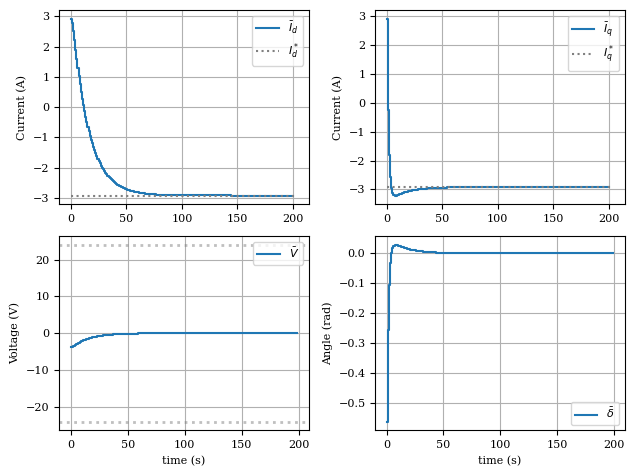

In [ ]:
# Plot state and input trajectories with Kfit
axs = []
axs += [plt.subplot(2, 2, 1)]
plt.plot(np.array(xs)[:, 0], label=r'$\bar{I}_d$', drawstyle='steps-post')
plt.plot(x_refs[0, :], label='$I_d^*$', linestyle=':', drawstyle='steps-post', color='gray')
plt.legend(), plt.grid(which='both'), plt.ylabel('Current (A)')
axs += [plt.subplot(2, 2, 2)]
plt.plot(np.array(xs)[:, 1], label=r'$\bar{I}_q$', drawstyle='steps-post')
plt.plot(x_refs[1, :], label='$I_q^*$', linestyle=':', drawstyle='steps-post', color='gray')
plt.legend(), plt.grid(which='both'), plt.ylabel('Current (A)')

axs += [plt.subplot(2, 2, 3)]
plt.plot(np.array(us)[:, 0], label=r'$\bar{V}$', drawstyle='steps-post')
plt.axhline(v_max, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.axhline(v_min, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.legend(), plt.grid(), plt.xlabel('time (s)'), plt.ylabel('Voltage (V)')
axs += [plt.subplot(2, 2, 4)]
plt.plot(np.array(us)[:, 1], label=r'$\bar{\delta}$', drawstyle='steps-post')
plt.axhline(delta_max, linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(np.array(us)[:, 1]) >= delta_max else None  # Only plot limits if the input hits or exceeds them
plt.axhline(delta_min, linestyle=':', color='gray', linewidth=2, alpha=0.5) if np.max(np.array(us)[:, 1]) >= delta_max else None
plt.legend(), plt.grid(), plt.xlabel('time (s)'), plt.ylabel('Angle (rad)')
plt.tight_layout()

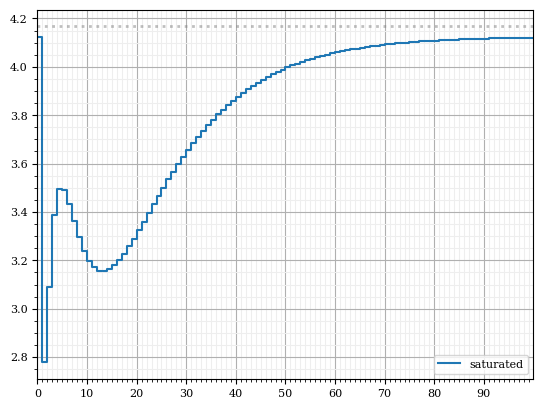

In [ ]:
# Plot the magnitude of the states over time
x_magnitude = np.linalg.norm(xs, axis=1)
plt.axhline(x_norm_max, linestyle=':', color='gray', linewidth=2, alpha=0.5)
plt.plot(x_magnitude, drawstyle='steps-post', label='saturated');
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xticks(np.arange(0, 100, 1), minor=True)
plt.xticks(np.arange(0, 100, 10))
plt.grid(which='minor', color='#EEEEEE', linestyle='-', linewidth=0.75)
plt.xlim(0, 100);

In [ ]:
# Evaluate and compare costs
cost_Kfit = cost(xs_Kfit, us_Kfit, x_refs.T, cost_args)
print("K fit cost: %s, MPC cost: %s, Linear K cost: %s" % (cost_Kfit, cost_mpc, cost_K))

K fit cost: 382.4852945456504, MPC cost: 411.54405714637255, Linear K cost: 577.2712809147132


# Simulation results

Run tests comparing the base-line controller and the MPC fit controller

In [331]:
t_test = 0.5
T_test = int(t_test / delta_t)
T_test_max = int(1.0 / delta_t)
T_test_min = T_test

#######################
mag_sweep_steps = 3 # 4
rad_sweep_steps = 4 # 4
rad_sweep_start = np.pi / 4

x0_mag_sweep_bounds = [0.0, i_max-1e-6]  # Bounds on the magnitudes for x0, xref
xref_mag_sweep_bounds = [0.0, i_max-1e-6]  # Bounds on the magnitudes for x0, xref
rad_sweep_bounds = [0, 2*np.pi - 2*np.pi / rad_sweep_steps]  # Bounds on the angles for x0, xref
# Drop the 2*pi value to avoid repeated tests (cos(2*pi) = cos(0) = 1)
#######################

# Polar coordinates sweep over magnitude limiter
x0_mag_sweep = np.linspace(x0_mag_sweep_bounds[0], x0_mag_sweep_bounds[1], mag_sweep_steps)
xref_mag_sweep = np.linspace(xref_mag_sweep_bounds[0], xref_mag_sweep_bounds[1], mag_sweep_steps)
rad_sweep = np.linspace(rad_sweep_bounds[0], rad_sweep_bounds[1], rad_sweep_steps) + rad_sweep_start

# Create a mesh grid of the sweep values
x0_mag, x0_rad, xref_mag, xref_rad = np.meshgrid(x0_mag_sweep, rad_sweep, xref_mag_sweep, rad_sweep)

# Convert polar to cartesian coordinates
id_ref_values = xref_mag * np.cos(xref_rad)
iq_ref_values = xref_mag * np.sin(xref_rad)

x0_rad_offset = 0 # np.pi / rad_sweep_steps
x0_id_values = x0_mag * np.cos(x0_rad + x0_rad_offset)
x0_iq_values = x0_mag * np.sin(x0_rad + x0_rad_offset)

n_test_cases = len(id_ref_values.flatten())

test_x0s = np.vstack([x0_id_values.ravel(), x0_iq_values.ravel()])
test_xrefs = np.vstack([id_ref_values.ravel(), iq_ref_values.ravel()])
tested_xrefs = []
tested_x0s = []

args_kfit = [K_fit]
args_k = [K_base]

K_xs_store = []
Kfit_xs_store = []
K_us_store = []
Kfit_us_store = []
mpc_xs_store = []
costs = []
tests_ran = 0
for i, (x0, x_ref) in enumerate(zip(test_x0s.T, test_xrefs.T)):
  print('Test %s / %s' % (i, n_test_cases))
  print('Completed %s tests' % tests_ran)

  valid_xref = check_x0_2norm(x_ref, x_norm_max)
  valid_x0 = check_x0_2norm(x0, x_norm_max)
  print("x_ref is valid?:", valid_xref, x_ref)
  print("x0 is valid?:", valid_x0, x0)
  if not(valid_xref[0] and valid_x0[0]):
    print("NOT RUNNING SIMULATIONS")
  else:
    tested_xrefs.append(x_ref)
    tested_x0s.append(x0)
    tests_ran += 1
    x0_sim = x0 - x_ref

    sat_u_args = [u_min, u_max]
    sat_x_args = [x_norm_max, x_ref]
    end_sim_funcs = [time_limit_reached, states_converged]

    print("Simulating with x0: %s, x_ref: %s, x0_sim: %s" % (x0, x_ref, x0_sim))
    x_ref_sim = np.zeros(n)  # Set x_ref to 0 as we are centering x_ref to be the origin

    xs_kfit, us_kfit = simulate_saturated_discrete_linear_system(A_num, B_num, linear_feedback_control, LQR_cost,
                                                               x0_sim, x_ref_sim, end_sim_funcs,
                                                               saturate_2norm, saturate, verbose=T_test//2,
                                                               args=args_kfit, end_sim_args=[(T_test_max,), (1e-2, 5, T_test_min)],
                                                               sat_x_args=sat_x_args, sat_u_args=sat_u_args)

    Kfit_xs_store.append(xs_kfit)
    Kfit_us_store.append(us_kfit)
    cost_kfit = cost(xs_kfit, us_kfit, x_ref_sim.T, cost_args)

    xs_k, us_k = simulate_saturated_discrete_linear_system(A_num, B_num, linear_feedback_control, LQR_cost,
                                                           x0_sim, x_ref_sim, end_sim_funcs,
                                                           saturate_2norm, saturate, verbose=T_test//2,
                                                           args=args_k, end_sim_args=[(T_test_max,), (1e-2, 5, T_test_min)],
                                                           sat_x_args=sat_x_args, sat_u_args=sat_u_args)
    K_xs_store.append(xs_k)
    K_us_store.append(us_k)
    cost_k = cost(xs_k, us_k, x_ref_sim.T, cost_args)

    # #NOTE: If you really wanna wait you can run MPC for each test for comparison as follows...
    # args_mpc = [N, x_ref_sim[:, 0], u_max, u_min, x_norm_max, cost_args]
    # xs_mpc, us_mpc = simulate_saturated_discrete_linear_system(A_num, B_num, mpc_control, LQR_cost, x0_sim, x_ref_sim,
    #                                                            T_test, saturate_2norm, saturate, verbose=T_test//1000,
    #                                                            args=args_mpc, sat_x_args=sat_x_args, sat_u_args=sat_u_args, b=b)
    # mpc_xs_store.append(xs_mpc)
    # cost_mpc = cost(xs_mpc, us_mpc, x_ref_sim.T, cost_args)
    # costs.append([cost_kfit, cost_k, cost_mpc])

    costs.append([cost_kfit, cost_k])#, cost_mpc])


Test 0 / 144
Completed 0 tests
x_ref is valid?: (True, 0.0) [0. 0.]
x0 is valid?: (True, 0.0) [0. 0.]
Simulating with x0: [0. 0.], x_ref: [0. 0.], x0_sim: [0. 0.]
simulation t=0
simulation t=2500
simulation t=5000
simulation complete
simulation t=0
simulation t=2500
simulation t=5000
simulation complete
Test 1 / 144
Completed 1 tests
x_ref is valid?: (True, 0.0) [-0.  0.]
x0 is valid?: (True, 0.0) [0. 0.]
Simulating with x0: [0. 0.], x_ref: [-0.  0.], x0_sim: [0. 0.]
simulation t=0
simulation t=2500
simulation t=5000
simulation complete
simulation t=0
simulation t=2500
simulation t=5000
simulation complete
Test 2 / 144
Completed 2 tests
x_ref is valid?: (True, 0.0) [-0. -0.]
x0 is valid?: (True, 0.0) [0. 0.]
Simulating with x0: [0. 0.], x_ref: [-0. -0.], x0_sim: [0. 0.]
simulation t=0
simulation t=2500
simulation t=5000
simulation complete
simulation t=0
simulation t=2500
simulation t=5000
simulation complete
Test 3 / 144
Completed 3 tests
x_ref is valid?: (True, 0.0) [ 0. -0.]
x0 is v

In [332]:
# Compare the costs of the fit and base controllers
costs = np.array(costs)
mean_costs = np.mean(costs, axis=0)
print('Mean K_{fit} cost:\t', mean_costs[0])
print('Mean K cost:\t\t', mean_costs[1])

Mean K_{fit} cost:	 73.9893061443146
Mean K cost:		 112.4097739985609


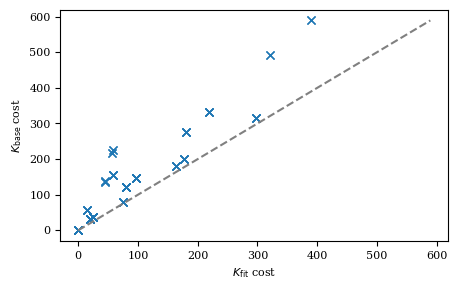

In [333]:
# Plots the costs of each controller against each other to see which is greater for each case
fig = plt.figure(figsize=(5, 3))
plt.plot(costs[:, 0], costs[:, 1], marker='x', linestyle=' ')
plt.plot([0, np.max(costs)], [0, np.max(costs)], linestyle='--', color='gray')
plt.xlabel('$K_\mathrm{fit}$ cost')
plt.ylabel('$K_\mathrm{base}$ cost');

In [334]:
# Check if the fit controller performs worse for any tested transient
K_lower_cost_idxs = np.where(costs[:, 0] > costs[:, 1])
Kfit_lower_cost_idxs = np.where(costs[:, 0] < costs[:, 1])
print("Number of cases where K_{fit} performs worse:", len(K_lower_cost_idxs[0]))

# Find the test cases for which the current saturates
K_mags = np.array([np.linalg.norm(xs + x_refs.T, axis=1) for xs, x_refs in zip(K_xs_store, tested_xrefs)])
Ktest_sat_idxs = np.where(np.array([np.max(mags) for mags in K_mags]) >= x_norm_max)[0]

Kfit_mags = np.array([np.linalg.norm(xs + x_refs.T, axis=1) for xs, x_refs in zip(Kfit_xs_store, tested_xrefs)])
test_sat_idxs = np.where(np.array([np.max(mags) for mags in Kfit_mags]) >= x_norm_max)[0]

# Find the simulation for which one of the controllers had the largest cost
max_indices = np.unravel_index(np.argmax(costs), costs.shape)
max_indices

# Find the test case for which the fit controller performed the worst
max_indices_Kfit = (np.argmax(costs[:, 0]), 0)
max_indices_Kfit

# Select feature plot here
j = 0
#i_plot = K_lower_cost_idxs[0][0] if len(K_lower_cost_idxs[0]) > 0 else test_sat_idxs[j]
i_plot = max_indices[0]

print('Plot Test: ', i_plot)
print('x0 =',tested_x0s[i_plot], ', xref=', tested_xrefs[i_plot])
print('Kfit cost:', costs[i_plot, 0], 'K cost:', costs[i_plot, 1])

j = 0
test_idx = test_sat_idxs[j] #max_indices[0]
print('Featured Test: ', test_idx)
print('x0 =',tested_x0s[test_idx], ', xref=', tested_xrefs[test_idx])
print('Kfit cost:', costs[test_idx, 0], 'K cost:', costs[test_idx, 1])

xref_test = tested_xrefs[test_idx]
x0_test = tested_x0s[test_idx]

Number of cases where K_{fit} performs worse: 0
Plot Test:  34
x0 = [2.94627755 2.94627755] , xref= [-2.94627755 -2.94627755]
Kfit cost: 390.2511080023321 K cost: 589.1187910855094
Featured Test:  35
x0 = [2.94627755 2.94627755] , xref= [ 2.94627755 -2.94627755]
Kfit cost: 56.93283694831286 K cost: 218.51432805502685


## Compare MPC-fit and Base-line controller

In [335]:
# Set up data for plotting
x0 = x0_test
x_ref = xref_test

xs_Kfit = np.array(Kfit_xs_store[test_idx])
xs_K = np.array(K_xs_store[test_idx])

us_Kfit = np.array(Kfit_us_store[test_idx])
us_K = np.array(K_us_store[test_idx])

In [336]:
# Run MPC response here for one selected response
#NOTE: Running this for the full T_test period takes a long time.
#      Maybe just run for a shorter time period or until it settles.
x0_sim = x0 - x_ref

sat_u_args = [u_min, u_max]
sat_x_args = [x_norm_max, x_ref]

print("Simulating with x0: %s, x_ref: %s, x0_sim: %s" % (x0, x_ref, x0_sim))
x_ref_sim = np.zeros(n) #np.zeros((1, T_test + N + 1))  # Set x_ref to 0 as we are centering x_ref to be the origin

args_mpc = [N, x_ref, u_max, u_min, x_norm_max, cost_args]

converge_tol = 1e-5
converge_steps = 10

end_sim_funcs = [time_limit_reached, states_converged]  # Simulate only until converged
t0 = time.time()
xs_mpc, us_mpc = simulate_saturated_discrete_linear_system(A_num, B_num, mpc_control, LQR_cost, x0_sim, x_ref_sim,
                                                   end_sim_funcs, saturate_2norm, saturate, verbose=10,
                                                   args=args_mpc, end_sim_args=[(T_test-1,), (converge_tol, converge_steps)],
                                                   sat_x_args=sat_x_args, sat_u_args=sat_u_args)
t1 = time.time()
runtime_total = t1-t0
print("runtime:", runtime_total, 's')

xs_MPC = np.array(xs_mpc)
us_MPC = np.array(us_mpc)

T_MPC = xs_MPC.shape[0]
xs_MPC = np.vstack([xs_MPC, np.zeros((T_test - T_MPC + 1, n))])  #NOTE: FILLING IN VALUES PAST T_test_mpc with ZEROS.
us_MPC = np.vstack([us_MPC, np.zeros((T_test - T_MPC + 1, n))])  #      THIS IS ASSUMED TO BE CORRECT AS THE SYSTEM HAS SETTLED

cost_mpc = cost(xs_MPC, us_MPC, x_ref_sim, cost_args)
print("MPC cost: ", cost_mpc)

Simulating with x0: [2.94627755 2.94627755], x_ref: [ 2.94627755 -2.94627755], x0_sim: [8.8817842e-16 5.8925551e+00]
simulation t=0
simulation t=10
simulation t=20
simulation complete
runtime: 5.540624380111694 s
MPC cost:  57.844699228651066


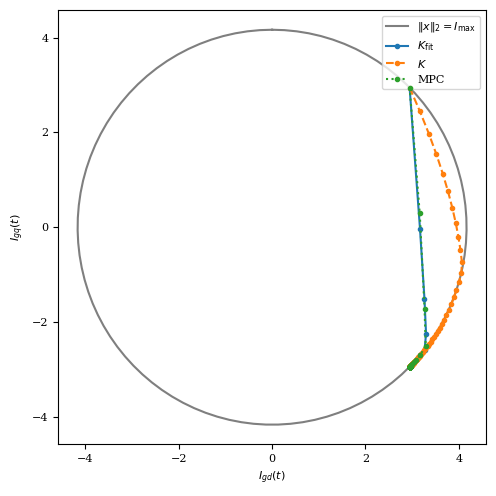

In [337]:
plt_to_i = 100

fig = plt.figure(figsize=(5,5))
plot_circle(x_norm_max, np.zeros(n), fig=fig, plt_args={'label': "$\|x\|_2=I_\mathrm{max}$", 'linestyle': '-', 'color': 'C7'});  # Circular limiter

xs_Kfit_xref = xs_Kfit + x_ref
xs_K_xref = xs_K + x_ref
xs_MPC_xref = xs_MPC + x_ref

plt.plot(xs_Kfit_xref[:plt_to_i, 0], xs_Kfit_xref[:plt_to_i, 1],
         label="$K_\mathrm{fit}$", marker='.', zorder=4)
plt.plot(xs_K_xref[:plt_to_i, 0], xs_K_xref[:plt_to_i, 1],
         label="$K_\mathrm{}$", marker='.', linestyle="--", zorder=5);
plt.plot(xs_MPC_xref[:plt_to_i, 0], xs_MPC_xref[:plt_to_i, 1],
         label="MPC", marker='.', linestyle=':', zorder=6);  # NOTE: Plot full-order starting from step
plt.legend(loc='upper right')

# Set zoom
# plt.xlim(-2.5, 3.5)
# plt.ylim(-4.5, 1.5)

plt.xlabel("$I_{gd}(t)$");
plt.ylabel("$I_{gq}(t)$");

plt.tight_layout()

fname="id-vs-iq_trajectory_K-vs-Kfit.eps"
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

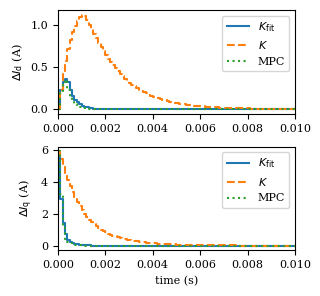

In [338]:
# Plot comparison of currents  over time
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*1.5))

ts_test = np.linspace(0, t_test, int(round(1 / delta_t * t_test)))

axs = []
n_simplified = len(x_reduced)
for i, state in enumerate(x_reduced):
  ax = plt.subplot(n_simplified, 1, (1*i)+1)
  axs.append(ax)
  x_sym = '$K_\mathrm{fit}$'
  plt.plot(ts_test[:T_test], xs_Kfit[:T_test, i], label=x_sym, drawstyle='steps-post')

for i, state in enumerate(x_reduced):
  plt.subplot(n_simplified, 1, (1*i)+1)
  x_sym = '$K$'
  plt.plot(ts_test[:T_test], xs_K[:T_test, i], label=x_sym, drawstyle='steps-post',
           linestyle='--')

for i, state in enumerate(x_reduced):
  plt.subplot(n_simplified, 1, (1*i)+1)
  x_sym = 'MPC'
  plt.plot(ts_test[:T_test], xs_MPC[:T_test, i], label=x_sym, drawstyle='steps-post',
           linestyle=':')

for ax in axs:
  ax.set_xlim(-0.00001, 0.01)
  ax.legend()
axs[0].set_ylabel('$\Delta I_\mathrm{d}$ (A)');
axs[1].set_ylabel('$\Delta I_\mathrm{q}$ (A)');
plt.xlabel('time (s)');

plt.tight_layout()

fname="idq-vs-time_trajectory_K-vs-Kfit.eps"
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

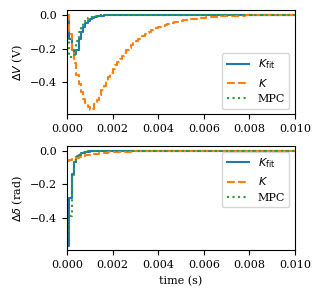

In [339]:
# Plot the comparison of inputs over time
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*1.5))

axs = []
m_simplified = len(u_vars)
for i, input in enumerate(u_vars):
  ax = plt.subplot(m_simplified, 1, (1*i)+1)
  axs.append(ax)
  label = '$K_\mathrm{fit}$'
  plt.plot(ts_test[:T_test], us_Kfit[:T_test, i], label=label, drawstyle='steps-post')

for i, input in enumerate(u_vars):
  plt.subplot(m_simplified, 1, (1*i)+1)
  label = '$K$'
  plt.plot(ts_test[:T_test], us_K[:T_test, i], label=label, drawstyle='steps-post',
           linestyle='--')

for i, input in enumerate(u_vars):
  plt.subplot(n_simplified, 1, (1*i)+1)
  label = 'MPC'
  plt.plot(ts_test[:T_test], us_MPC[:T_test, i], label=label, drawstyle='steps-post',
           linestyle=':')

for ax in axs:
  ax.set_xlim(-0.00001, 0.01)
  ax.legend()
axs[0].set_ylabel('$\Delta V$ (V)');
axs[1].set_ylabel('$\Delta \delta$ (rad)');
plt.xlabel('time (s)');

plt.tight_layout()

fname="inputs-vs-time_K-vs-Kfit.eps"
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

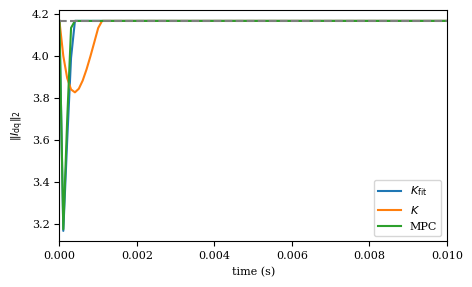

In [340]:
# Plot comparison of current magnitude over time
axs = []

mag_xs_Kfit = np.array([np.sqrt(x.T @ x.T) for x in xs_Kfit_xref[:T_test, :]])
mag_xs_K = np.array([np.sqrt(x.T @ x.T) for x in xs_K_xref[:T_test, :]])
mag_xs_MPC = np.array([np.sqrt(x.T @ x.T) for x in xs_MPC_xref[:T_test, :]])

plt.figure(figsize=(5, 3))
plt.plot(ts_test[:T_test], mag_xs_Kfit[:T_test], label=r"$K_\mathrm{fit}$")
plt.plot(ts_test[:T_test], mag_xs_K[:T_test], label=r"$K$")
plt.plot(ts_test[:T_test], mag_xs_MPC[:T_test], label=r"MPC")

for ax in axs:
  ax.set_xlim(-0.00001, 0.01)
  ax.legend()
plt.xlabel('time (s)');
plt.ylabel('$\|I_\mathrm{dq}\|_2$')

plt.axhline(x_norm_max, linestyle='--', color='C7')

plt.legend()
plt.xlim(0, 0.01);

In [341]:
print('K: ', cost(K_xs_store[test_idx], K_us_store[test_idx], x_ref_sim.T, cost_args))
print('Kfit: ', cost(Kfit_xs_store[test_idx], Kfit_us_store[test_idx], x_ref_sim.T, cost_args))
print('MPC: ', cost_mpc)

K:  218.51432805502685
Kfit:  56.93283694831286
MPC:  57.844699228651066


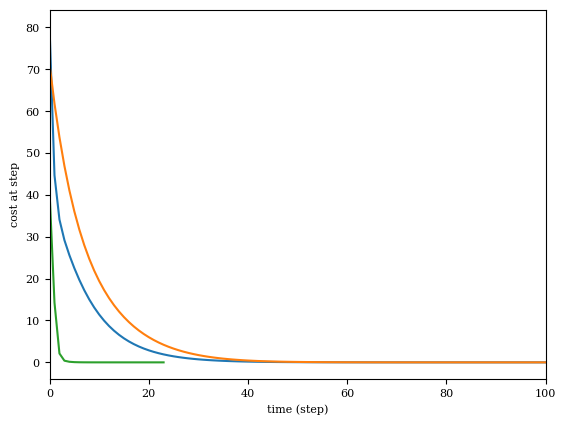

In [342]:
# Plot the cost incurred at each step
kfit_costs = [LQR_cost(x, u, x_ref_sim, Q=cost_args['Q'], R=cost_args['R']) for x, u in zip(Kfit_xs_store[i_plot], Kfit_us_store[i_plot])]
k_costs = [LQR_cost(x, u, x_ref_sim, Q=cost_args['Q'], R=cost_args['R']) for x, u in zip(K_xs_store[i_plot], K_us_store[i_plot])]
mpc_costs = [LQR_cost(x, u, x_ref_sim, Q=cost_args['Q'], R=cost_args['R']) for x, u in zip(xs_mpc, us_mpc)]

plt.plot(kfit_costs)
plt.plot(k_costs)
plt.plot(mpc_costs)
plt.xlabel('time (step)')
plt.ylabel('cost at step')
plt.xlim(0, 100);

# Compare simplified and full-order system models

In [344]:
x_fullorder, x_dot_fullorder

⎛                       ⎡                                                     
⎜                       ⎢                                                     
⎜                       ⎢                                                     
⎜                       ⎢                                                     
⎜                       ⎢                                                     
⎜                       ⎢                                                     
⎜⎡\delta_\mathrm{pll}⎤  ⎢                                                     
⎜⎢                   ⎥  ⎢                                                     
⎜⎢ \Pi_\mathrm{pll}  ⎥  ⎢                                                     
⎜⎢                   ⎥  ⎢                                                     
⎜⎢  \Phi_\mathrm{d}  ⎥  ⎢                                                     
⎜⎢                   ⎥  ⎢                                                     
⎜⎢  \Phi_\mathrm{q}  ⎥  ⎢                           

In [345]:
# Add saturation to the nonlinear system dynamics for simulation
sat = sym.Function('\mathrm{sat}')

i_dq_ref_sat = Matrix([[sat(i_d_ref)], [sat(i_q_ref)]])
i_dq_ref = Matrix([[i_d_ref], [i_q_ref]])

I_dq_fullorder_ref = Matrix([[I_d_ref], [I_q_ref]])
x_dot_fullorder_sat = x_dot_fullorder.subs(zip(I_dq_fullorder_ref, i_dq_ref_sat))
x_dot_fullorder_sat

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

## Simulate system with linear feedback controller, $K$, and PLL

In [346]:
# Select the linear feedback controller to run these tests with
K_test = K_fit

In [347]:
# Define states and dynamics using earlier system definition
x_K = Matrix(x_fullorder)
x_dot_K = Matrix(x_dot_fullorder)

display_diff_eq(x_K, x_dot_K)

                        ⎡                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
                        ⎢                                                     
⎡\delta_\mȧthrm{pll}⎤   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢ \Pi_\matḣrm{pll}  ⎥   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{d}  ⎥   ⎢                                                    
⎢                   ⎥   ⎢                                                     
⎢  \Phi_\mȧthrm{q}  ⎥   ⎢                          

In [348]:
# Define the inputs

# Add equilibrium values to the control terms
delta_eq, V_eq = dynamicsymbols("\delta^*, {V}^{*}")

u_terms = Matrix([[v_i], [delta_i]])
u_nom = Matrix([[V_eq], [delta_eq]])

Vd_ref, Vq_ref = sqrt(2)*V_eq, 0  #NOTE: Capacitor voltage (controlled to output of power controller) aligns with PLL at the end

y_ref = 2/3 * 1/(Vd_ref**2 + 0**2) * Matrix([[Vd_ref, 0], [0, -Vd_ref]]) @ Matrix([[p_ref], [q_ref]])  # = i_d*, i_q*
y_ref_vals = y_ref.subs(p_ref, pref0).subs(q_ref, qref0).subs(V_eq, v_nom_val).subs(w_d, v_nom_val).subs(w_q, 0).evalf()
y_terms = Matrix([[i_g_d], [i_g_q]])

u_expr = u_nom - K_test @ (y_terms - y_ref)

display_alg_eq(u, u_expr)

            ⎡  0.216957806513394⋅√2⋅P__*                                      
            ⎢  ───────────────────────── - 0.650873419540181⋅I_{g\mathrm{d}} +
⎡  Vᵢ   ⎤   ⎢           {V}__{*}                                              
⎢       ⎥ = ⎢                                                                 
⎣\deltaᵢ⎦   ⎢  0.0321538712454303⋅√2⋅Q__*                                     
            ⎢- ────────────────────────── - 0.0964616137362908⋅I_{g\mathrm{q}}
            ⎣           {V}__{*}                                              

            ⎤
 {V}__{*}   ⎥
            ⎥
            ⎥
            ⎥
 + \delta__*⎥
            ⎦


## Equilibrium analysis

In [349]:
# Steady-state power calculations
"""
Simulation parameters defined here
"""
delta = Symbol("\delta")

pref_ss, qref_ss = 750, 750
numeric_subs[p_ref] = pref_ss
numeric_subs[q_ref] = qref_ss

y11 = 1 / (r_g_val + 2*np.pi*60j*l_g_val)
y12 = -y11

g11, b11 = np.real(y11), np.imag(y11)
g12, b12 = np.real(y12), np.imag(y12)

v2 = e_val
P_ss = 3 * (v_i**2 *  g11 + v_i*v2 * (g12*sym.cos(delta) + b12*sym.sin(delta)))
Q_ss = 3 * (v_i**2 * -b11 + v_i*v2 * (g12*sym.sin(delta) - b12*sym.cos(delta)))

V_ref, delta_ref = nsolve([P_ss - pref_ss, Q_ss - qref_ss], [v_i, delta], [v_nom_val, 0])
delta_ref = 0  # The PLL controls the angle difference to the steady-state value

x_dot_numeric = x_dot_K.subs(zip(u_terms, u_expr)).subs(control_subs).subs(symbolic_subs).subs(numeric_subs).evalf()
x_dot_numeric = x_dot_numeric.subs(V_eq, V_ref).subs(delta_eq, delta_ref)
x_dot_numeric

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢2233.23654388444⋅(125.217346252777 - 0.650873419540

In [350]:
# Solve for the equilibrium values to validate power calculations
x_eq_guess = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, y_ref_vals[0], y_ref_vals[1], np.sqrt(2)*v_nom_val, 0.1, y_ref_vals[0], y_ref_vals[1])
equilibrium_values = nsolve(x_dot_numeric.evalf(), x_K, x_eq_guess, verbose=False)
Eq(x_K, equilibrium_values)

⎡\delta_\mathrm{pll}⎤   ⎡-0.00246614951615707⎤
⎢                   ⎥   ⎢                    ⎥
⎢ \Pi_\mathrm{pll}  ⎥   ⎢         0          ⎥
⎢                   ⎥   ⎢                    ⎥
⎢  \Phi_\mathrm{d}  ⎥   ⎢9.5555536537725e-19 ⎥
⎢                   ⎥   ⎢                    ⎥
⎢  \Phi_\mathrm{q}  ⎥   ⎢9.97964132722717e-21⎥
⎢                   ⎥   ⎢                    ⎥
⎢ \Gamma_\mathrm{d} ⎥   ⎢4.56173074248848e-5 ⎥
⎢                   ⎥   ⎢                    ⎥
⎢ \Gamma_\mathrm{q} ⎥   ⎢-4.45706326949893e-5⎥
⎢                   ⎥ = ⎢                    ⎥
⎢  I_{i\mathrm{d}}  ⎥   ⎢  2.86621995765141  ⎥
⎢                   ⎥   ⎢                    ⎥
⎢  I_{i\mathrm{q}}  ⎥   ⎢ -2.80045544480857  ⎥
⎢                   ⎥   ⎢                    ⎥
⎢  W_{\mathrm{d}}   ⎥   ⎢  174.445788316156  ⎥
⎢                   ⎥   ⎢                    ⎥
⎢  W_{\mathrm{q}}   ⎥   ⎢         0          ⎥
⎢                   ⎥   ⎢                    ⎥
⎢  I_{g\mathrm{d}}  ⎥   ⎢  2.86621995765141  ⎥
⎢            

In [351]:
# Check that output currents track the reference currents and save values for simplified system simulation
idq_ref = y_ref.subs(p_ref, pref_ss).subs(q_ref, qref_ss).subs(w_d, equilibrium_values[-4]).subs(w_q, equilibrium_values[-3]).subs(V_eq, V_ref).evalf()
idq_ref_norm = np.linalg.norm(np.array(idq_ref).astype(np.float64))
print("Valid idq_ref: ", idq_ref_norm < x_norm_max, "%s < %s" % (idq_ref_norm, x_norm_max))
idq_ref, idq_ref_norm

Valid idq_ref:  True 4.053447136855077 < 4.166666666666667


⎛⎡2.86621995765142 ⎤                   ⎞
⎜⎢                 ⎥, 4.053447136855077⎟
⎝⎣-2.86621995765142⎦                   ⎠

In [352]:
# Check small-signal stability of the full-order system
A_linearized = x_dot_numeric.jacobian(x_K).subs(zip(x_K, equilibrium_values)).evalf()
A_evals = np.linalg.eigvals(np.array(A_linearized).astype(np.float64))
print("Small-signal stable?: ", np.all(np.real(A_evals) < 0))
A_evals # All eigenvalues have negative real-part

Small-signal stable?:  True


array([-2.91207333e+04+31024.06368373j, -2.91207333e+04-31024.06368373j,
       -2.49883866e+04+27763.14290739j, -2.49883866e+04-27763.14290739j,
       -6.63800849e+03 +1575.38520637j, -6.63800849e+03 -1575.38520637j,
       -4.05582301e+03    +0.j        , -1.04159650e+03    +0.j        ,
       -4.85579084e+02    +0.j        , -3.20497611e+00    +0.j        ,
       -2.66607436e+02    +0.j        , -2.66666667e+02    +0.j        ])

## Simulate nonlinear system

In [353]:
# Add in saturation on the current referecne
I_dq_ref_K = Matrix([[I_d_ref], [I_q_ref]])
x_dot_K_sat = x_dot_K.subs(zip(I_dq_ref_K, i_dq_ref_sat))

In [354]:
# Substitute in parameter values for simulations
sim_num_subs = dict(numeric_subs)
sim_num_subs.pop(p_ref);
sim_num_subs.pop(q_ref);
sim_num_subs

i_dq_ref_num_sim = I_dq_ref_K.subs(zip(u_terms, u_expr)).subs(control_subs).subs(symbolic_subs).subs(sim_num_subs).evalf()

x_dot_num_sim = x_dot_K_sat.subs(zip(u_terms, u_expr)).subs(control_subs).subs(symbolic_subs).subs(sim_num_subs).evalf()

x_dot_num_sim

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                      ⎛0.306824672433959⋅P__*
⎢                                      1.4142135623731⋅⎜──────────────────────
⎢                                                      ⎝       {V}__{*}       
⎢                                                                             
⎢                                                       ⎛0.306824672433959⋅P__
⎢                                     - 1.4142135623731⋅⎜─────────────────────
⎢                                                       ⎝       {V}__{*}      
⎢                                                                             
⎢                                                   

In [355]:
# Define the dynamics functions for the ODE solver
t = Symbol('t')
xt = [x_K, t, p_ref, q_ref]
xt_pq_vd = [x_K, t, p_ref, q_ref, V_eq, delta_eq]

lam_i_dq_ref = sym.lambdify(xt_pq_vd, i_dq_ref_num_sim)

xt_pq_vd_dq = [x_K, t, p_ref, q_ref, V_eq, delta_eq, sat(i_d_ref), sat(i_q_ref)]

lam_x_dot = sym.lambdify(xt_pq_vd_dq, x_dot_num_sim)

def sat_fx(x, x_norm_max=1):
  return x_norm_max * x / np.maximum(np.linalg.norm(x, ord=2), x_norm_max)

def f_x_dot(x, t, p_ref, q_ref, V_eq, delta_eq):
  i_d_ref, i_q_ref = sat_fx(lam_i_dq_ref(x, t, p_ref, q_ref, V_eq, delta_eq), x_norm_max)
  return lam_x_dot(x, t, p_ref, q_ref, V_eq, delta_eq, i_d_ref[0], i_q_ref[0])[:, 0]

# NOTE: f_u not used for simulations below.
lam_u = sym.lambdify(xt_pq_vd, u_expr.subs(sim_num_subs))
def f_u(x, t, p_ref, q_ref, V_eq, delta_eq):
  return lam_u(x, t, p_ref, q_ref, V_eq, delta_eq)[:, 0]

In [356]:
# Create an unsaturated system dynamics matrix for solving for equilibrium values
x_dot_num_unsat = x_dot_K.subs(zip(u_terms, u_expr)).subs(control_subs).subs(symbolic_subs).subs(sim_num_subs).evalf()

In [357]:
# Run the simulation
t_sim = 0.2
ts = np.linspace(0, t_sim, int(round(1 / delta_t * t_sim)))

ts1 = ts[:len(ts)//4]
ts2 = ts[len(ts)//4:]

#NOTE: Edit the full-order model v.s. simplified model simulation reference values (pref0_sim, pref_sim) here
pref0_sim = 0
qref0_sim = 0
# pref0_sim = 750
# qref0_sim = 750

v_ref0, delta_ref0 = nsolve([P_ss - pref0_sim, Q_ss - qref0_sim], [v_i, delta], [v_nom_val, 0])
delta_ref0 = 0

x0 = sym.nsolve(x_dot_num_unsat.subs({p_ref: pref0_sim, q_ref: qref0_sim, V_eq: v_ref0, delta_eq: delta_ref0}).evalf(),
                x_K, x_eq_guess, dict=False)
x0 = np.array(x0).astype(np.float64).flatten()

xs1 = sp.integrate.odeint(f_x_dot, x0, ts1, args=(pref0_sim, qref0_sim, float(v_ref0), float(delta_ref0)))

# Rotate the reference values by 180 deg
# pqref_sim = np.array(Rmat(np.pi) @ np.array([[pref0_sim], [qref0_sim]])).astype(np.float64)
# pref_sim = int(round(pqref_sim[0, 0]))
# qref_sim = int(round(pqref_sim[1, 0]))

# or directly choose values here
pref_sim = 750
qref_sim = 750

v_ref1, delta_ref1 = nsolve([P_ss - pref_sim, Q_ss - qref_sim], [v_i, delta], [v_nom_val, 0])
delta_ref1 = 0
xs2 = sp.integrate.odeint(f_x_dot, xs1[-1], ts2, args=(pref_sim, qref_sim, float(v_ref1), float(delta_ref1)))
xs_fullorder = np.vstack([xs1, xs2])

In [358]:
# Create arrays used for plotting
pq_refs = np.ones((2, len(ts)))
pq_refs[0, :len(ts)//4] = pref0_sim
pq_refs[1, :len(ts)//4] = qref0_sim

pq_refs[0, len(ts)//4:] = pref_sim
pq_refs[1, len(ts)//4:] = qref_sim

v_refs = np.ones(len(ts))
delta_refs = np.ones(len(ts))

v_refs[:len(ts)//4] = v_ref0
v_refs[len(ts)//4:] = v_ref1
delta_refs[:len(ts)//4] = delta_ref0
delta_refs[len(ts)//4:] = delta_ref1

In [359]:
# Calculate the power values from the state values
p_calc = sym.lambdify(x_K, P_capacitor_grid)
q_calc = sym.lambdify(x_K, Q_capacitor_grid)

p_sim_values = [p_calc(*x_) for x_ in xs_fullorder]
q_sim_values = [q_calc(*x_) for x_ in xs_fullorder]

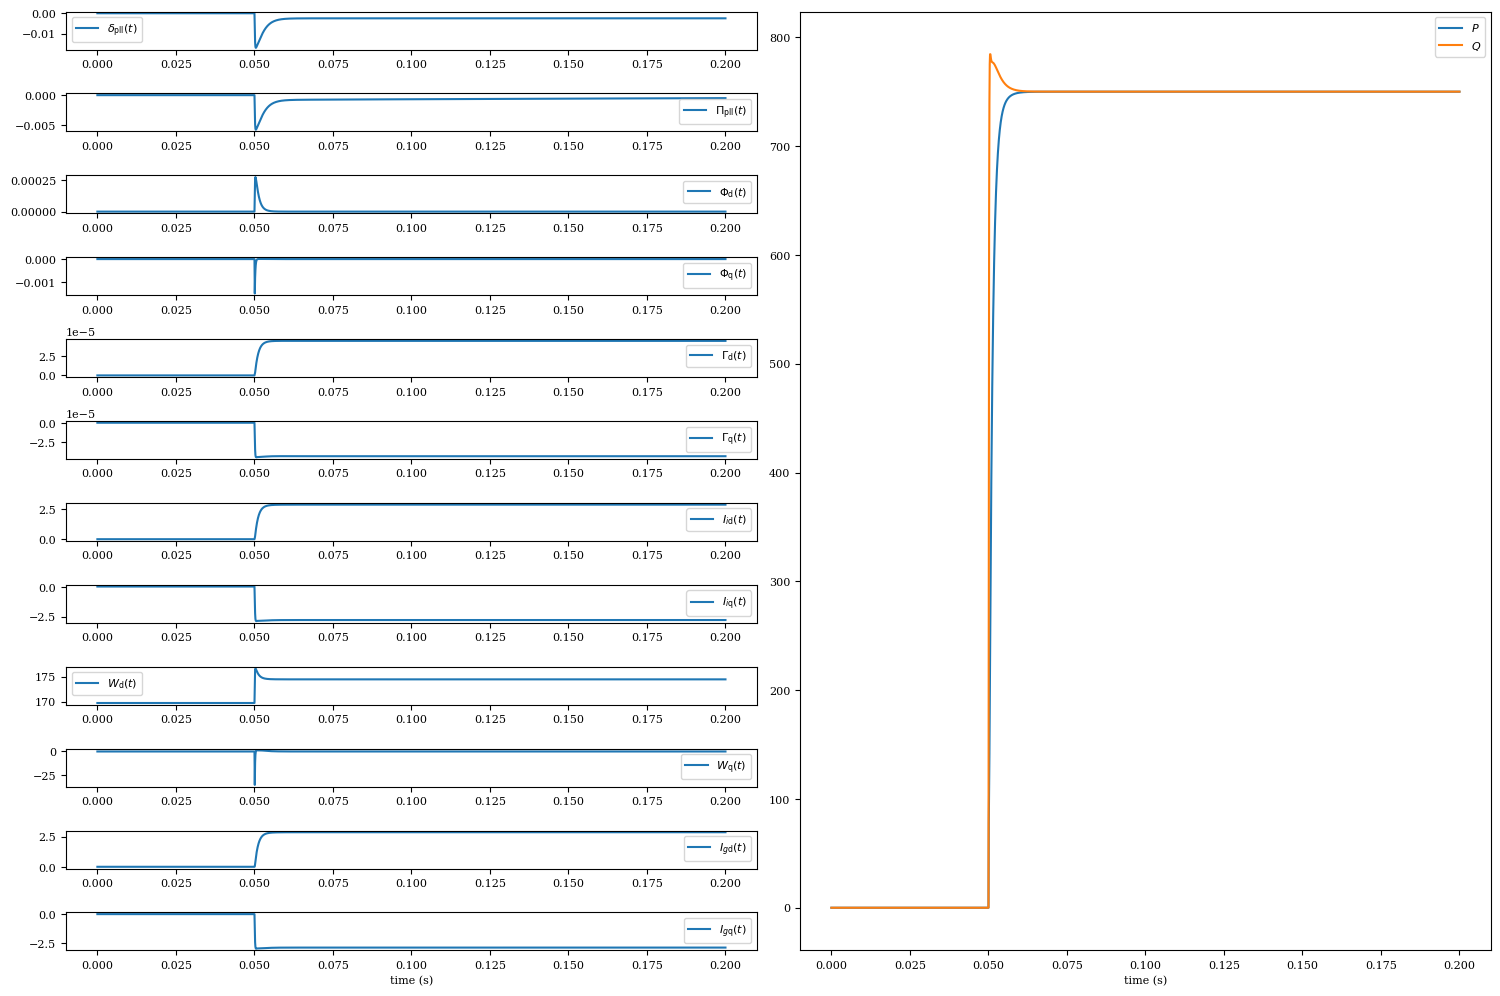

In [360]:
# Plot all state trajectories and the powers
plt.figure(figsize=(15,10))

n_nonlinear = len(x_K)
axs = []
for i, state in enumerate(x_K):
  ax = plt.subplot(n_nonlinear,2,(2*i)+1)
  plt.plot(ts, xs_fullorder[:, i])
  x_sym = '$'+sym.latex(state)+'$'
  plt.legend([x_sym]);
  axs.append(ax)

axs[-1].set_xlabel("time (s)")

plt.subplot(1,2,2)
plt.plot(ts, p_sim_values)
plt.plot(ts, q_sim_values)
plt.xlabel("time (s)")
plt.legend(["$P$", "$Q$"]);

plt.tight_layout()

## Simulate simplified system

In [361]:
# Finds Idq from a given set of PQ and Vdq values
def idq_from_PQ(p, q, vd, vq):
  pq = np.array([[p], [q]])
  vdq = np.array([[vd], [vq]])
  V = np.array([[vd, vq],
                [vq, -vd]])
  idq = 2/3 * 1 / (vdq.T @ vdq) * V @ pq
  return idq

In [362]:
# Find the equilibrium V value for the given P*,Q* with the full-order system
v_val_eq, delta_val_eq = nsolve(Matrix([P_ss - pref_sim, Q_ss - pref_sim]).subs(e, e_val), [v_i, delta], [v_nom_val, 0])

In [363]:
# Simulate the simplified system with the static linear feedback controller
T = int(t_sim / delta_t)  # NOTE: t_sim comes from nonlinear system simulation

# Full-order system uses pref0_sim, qref0_sim and pref_sim, pref_sim for steps in the reference

x0_simple = x0[10:]  # Take x0 from full-order system intialization
idq_ref = idq_from_PQ(pref_sim, qref_sim, np.sqrt(2)*v_val_eq, 0)
x_ref = np.array(idq_ref).astype(np.float64).flatten()  # Calculated above from P*, Q*
x0_sim = x0_simple - x_ref

x_ref_sim = np.zeros(n)  # Centered to x_ref for simulation so pass zeros to controller

sat_u_args = [u_min, u_max]
sat_x_args = [x_norm_max, x_ref]  #NOTE: Passing true x_ref to saturation function

args = [K_test]
end_sim_funcs = [time_limit_reached]
delta_xs, delta_us = simulate_saturated_discrete_linear_system(A_num, B_num, linear_feedback_control, LQR_cost,
                                                            x0_sim, x_ref_sim, end_sim_funcs,
                                                            saturate_2norm, saturate, verbose=T//10,
                                                            args=args, end_sim_args=[(T,)],
                                                            sat_x_args=sat_x_args, sat_u_args=sat_u_args)

xs_simple = delta_xs + x_ref.T
xs_Kfit = np.array(xs_simple)

simulation t=0
simulation t=200
simulation t=400
simulation t=600
simulation t=800
simulation t=1000
simulation t=1200
simulation t=1400
simulation t=1600
simulation t=1800
simulation t=2000
simulation complete


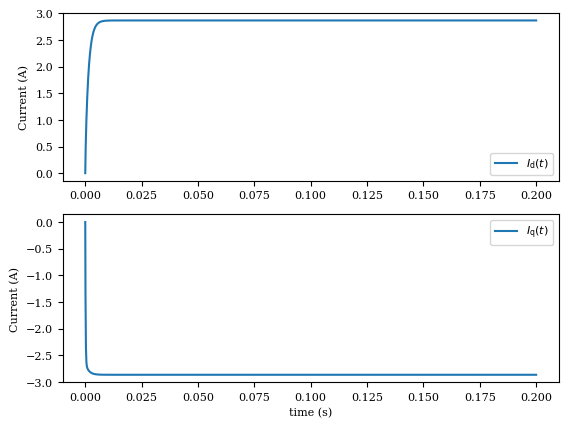

In [364]:
n_simplified = len(x_reduced)
for i, state in enumerate(x_reduced):
  plt.subplot(n_simplified, 1, (1*i)+1)
  plt.plot(ts, xs_Kfit[:T, i])
  x_sym = '$'+sym.latex(state)+'$'
  plt.legend([x_sym]);
  plt.ylabel("Current (A)")

plt.xlabel("time (s)");

## Compare simplified and full-order models

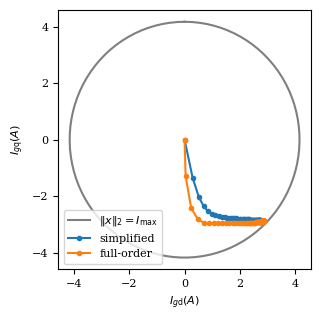

In [365]:
# Plot Id versus Iq to visualize the trajectories
plt_to_i = 100

fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[0]))
plot_circle(x_norm_max, np.zeros(n), fig=fig, plt_args={'label': "$\|x\|_2= I_\mathrm{max}$", 'linestyle': '-', 'color': 'C7'});  # Circular limiter

plt.plot(xs_simple[:plt_to_i, 0], xs_simple[:plt_to_i, 1], label="simplified", marker='.')
step_indx = len(ts)//4
plt.plot(xs_fullorder[step_indx:step_indx+plt_to_i, -2], xs_fullorder[step_indx:step_indx+plt_to_i, -1],  # Igdq is indices 10, 11 of xs_fullorder
         label="full-order", marker='.');  # NOTE: Plot full-order starting from step
plt.legend(loc='lower left')

plt.xlabel("$I_{g\mathrm{d}} (A)$");
plt.ylabel("$I_{g\mathrm{q}} (A)$");

plt.tight_layout()

fname="id-vs-iq_grid-side_trajectory_simplified-vs-fullorder-p%s-q%s-to-p%s-q%s.eps" % (pref0_sim, qref0_sim, pref_sim, qref_sim)
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

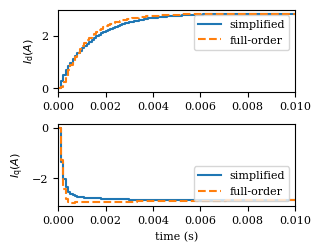

In [366]:
# Plot comparison of currents  over time
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*1.3))

axs = []
n_simplified = len(x_reduced)
for i, state in enumerate(x_reduced):
  ax = plt.subplot(n_simplified, 1, (1*i)+1)
  axs.append(ax)
  x_lbl = 'simplified'
  plt.plot(ts, xs_Kfit[:T, i], label=x_lbl, drawstyle='steps-post')

for i, state in enumerate(x_reduced):
  plt.subplot(n_simplified, 1, (1*i)+1)
  x_lbl = 'full-order'
  plt.plot(ts[:T-step_indx], xs_fullorder[step_indx:T, 10+i], label=x_lbl, drawstyle='steps-post', linestyle='--')

ax_labels = ['$I_\mathrm{d} (A)$', '$I_\mathrm{q} (A)$']
for i, ax in enumerate(axs):
  ax.set_xlim(-0.00001, 0.01)
  ax.set_ylabel(ax_labels[i]);
plt.xlabel('time (s)');

axs[0].legend()
axs[1].legend(loc='lower right')

plt.tight_layout()

fname="idq-vs-time_trajectory_simplified-vs-fullorder-p%s-q%s-to-p%s-q%s.eps" % (pref0_sim, qref0_sim, pref_sim, qref_sim)
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

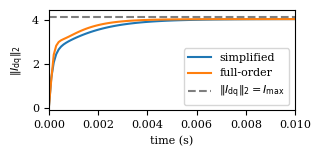

In [367]:
# Plot comparison of current magnitudes over time
fig = plt.figure(figsize=(dflt_figsize[0], dflt_figsize[1]*0.8))
axs = []

mag_xs_Kfit = np.array([np.sqrt(x.T @ x.T) for x in xs_Kfit[:T, :]])
mag_xs_fullorder = np.array([np.sqrt(x.T @ x.T) for x in xs_fullorder[step_indx:T, 10:]])  # Igdq is indices 10, 11 of xs_fullorder

plt.plot(ts, mag_xs_Kfit, label=r"simplified")
plt.plot(ts[:T-step_indx], mag_xs_fullorder, label=r"full-order")

for ax in axs:
  ax.set_xlim(-0.00001, 0.01)
  ax.legend()
plt.xlabel('time (s)');
plt.ylabel('$\|I_\mathrm{dq}\|_2$')

plt.axhline(x_norm_max, linestyle='--', color='C7', label="$\|I_\mathrm{dq}\|_2 = I_\mathrm{max}$")

plt.legend()
plt.xlim(0, 0.01);
plt.ylim(-0.1, x_norm_max+0.3)

plt.tight_layout()

fname="llidqll-vs-time_trajectory_simplified-vs-fullorder-p%s-q%s-to-p%s-q%s.eps" % (pref0_sim, qref0_sim, pref_sim, qref_sim)
plt.savefig(fname, dpi=300, format=None, metadata=None,
        bbox_inches=None, pad_inches=0.0,
        facecolor='auto', edgecolor='auto',
        backend=None
       )

The full-order model does not always come to the same equilibrium as the simplified model in these plots due to the power loss occuring across the LCL filter, which leads to the inverter-side currents exceeding the current limits of the inverter even though the grid-side currents required to satifsy the power reference are within the limits.

In [368]:
# End of Notebook